<a href="https://colab.research.google.com/github/lsbouchard/GradientPathologiesPINNs/blob/master/Copy_of_%E2%80%9Ctf_levenberg_marquardt_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Levenberg-Marquardt
### Install dependencies from GitHub

In [ ]:
import os

os.chdir("/content")

#lm_dir = "tf-levenberg-marquardt"
lm_dir = "lm"

if not os.path.exists(lm_dir):
  #!git clone https://github.com/fabiodimarco/$lm_dir
  !git clone https://github.com/qihengyuan/$lm_dir

os.chdir(lm_dir)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Feb 19 03:19:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import initializers
import random as python_random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from google.colab import drive
import tensorflow_datasets as tfds
from tensorflow.python.keras.engine import data_adapter
import scipy
import pywt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow import keras

tfl = tf.linalg

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Test mnist classification

The classification is performed using a Convolutional Neural Network with 1026 parameters.
This time there were no particular benefits as in the previous case. Even if Levenberg–Marquardt converges with far fewer epochs than Adam, the longer execution time per step nullifies its advantages.
However, both methods achieve roughly the same accuracy values on train and test set.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.cast(x_train / 255.0, dtype=tf.float32)
x_test = tf.cast(x_test / 255.0, dtype=tf.float32)

x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(60000)
train_dataset = train_dataset.batch(6000).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(10000)

# print("\n_________________________________________________________________")
# print("Test set results")

# test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
# print("adam - test_loss: %f - test_accuracy: %f" % (test_loss, test_acc))

# test_loss, test_acc = model_wrapper.evaluate(x=x_test, y=y_test, verbose=0)
# print("lm - test_loss: %f - test_accuracy: %f" % (test_loss, test_acc))


11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.cast(x_train / 255.0, dtype=tf.float32)
x_test = tf.cast(x_test / 255.0, dtype=tf.float32)

#x_train = tf.expand_dims(x_train, axis=-1)
#x_test = tf.expand_dims(x_test, axis=-1)

y_train = tf.one_hot(y_train.astype(np.int32), depth = 10)
y_train.shape
y_test = tf.one_hot(y_test.astype(np.int32), depth = 10)
y_test.shape

TensorShape([10000, 10])

In [ ]:
k = 10
cross_val = KFold(k, shuffle=True, random_state=1)
fold_count = 1

# For training epochs
epochs = 7

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

# For callbacks
es_callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)

In [ ]:
x_np = x_train.numpy()
y_np = y_train.numpy()

In [ ]:
for train, validation in cross_val.split(x_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1

    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid',
                           activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

    model_wrapper = ModelWrapper(tf.keras.models.clone_model(model))

    model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    solve_method='solve',
    metrics=['accuracy'])

    # model.compile(
    # optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # metrics=["accuracy"])

    x_cv_train, y_cv_train = x_np[train], y_np[train]
    x_cv_val, y_cv_val = x_np[validation], y_np[validation]

    history = model_wrapper.fit(x_cv_train, y_cv_train,
                        epochs=epochs, batch_size = 6000,
                        validation_data=(x_cv_val, y_cv_val))
                        #callbacks=[es_callbacks])
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model_wrapper.evaluate(x_test, y_test)

    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

In [ ]:
y_train.numpy().shape

(60000,)

In [ ]:
tf.keras.backend.set_floatx('float32')
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='valid',
                           activation='tanh', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=4, strides=2, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='linear')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 13, 13, 8)         136       
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 4)           516       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 4)           68        
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 4)           68        
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 4)           68        
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [ ]:
def reset_seeds():
   np.random.seed(123)
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid',
                           activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
    #tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 11, 11, 16)        4624      
                                                                 
 conv2d_46 (Conv2D)          (None, 9, 9, 8)           1160      
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 4)           292       
                                                                 
 flatten_11 (Flatten)        (None, 196)               0         
                                                     

In [ ]:
model_wrapper = ModelWrapper(tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    #loss=MeanSquaredError(),
    solve_method='solve',
    metrics=['accuracy'])

M = list()
N = list()
T = list()

print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
#model_wrapper.fit(train_dataset, epochs=5)
model_wrapper.fit(train_dataset, epochs=5, validation_data = test_dataset)
#model_wrapper.fit(x_train, y_train, epochs=5, batch_size = 6000, validation_data=(x_test, y_test))
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

Train using Levenberg-Marquardt
Epoch 1/5
10/10 [==============================] - 8s 638ms/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 1.2318 - accuracy: 0.6604 - val_loss: 0.5908 - val_accuracy: 0.9315
Epoch 2/5
10/10 [==============================] - 6s 626ms/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 0.3115 - accuracy: 0.9555 - val_loss: 0.2005 - val_accuracy: 0.9611
Epoch 3/5
10/10 [==============================] - 6s 628ms/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 0.1246 - accuracy: 0.9732 - val_loss: 0.1023 - val_accuracy: 0.9730
Epoch 4/5
10/10 [==============================] - 6s 625ms/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 0.0774 - accuracy: 0.9779 - val_loss: 0.0783 - val_accuracy: 0.9769
Epoch 5/5
10/10 [==============================] - 6s 622ms/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 0.0675 - accuracy: 0.9789 - val_loss: 0.0768 - val_accuracy: 0.9773
Elapsed time:  51.13093

In [ ]:
model_wrapper.evaluate(x_test, y_test, verbose = 1)

In [ ]:
loss1 = model_wrapper.trainer.batch_end_loss
acc1 = model_wrapper.trainer.batch_end_acc

In [ ]:
loss1

In [ ]:
381 * 8 / 50

60.96

In [ ]:
df1 = pd.DataFrame(acc1)
df1.to_csv('acc_1blk_mnist.csv')

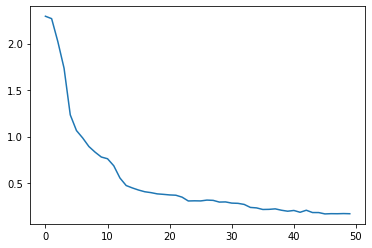

In [ ]:
plt.plot(loss1)

In [ ]:
print(sum(N)/ len(N))
print(sum(N))
print(len(N))

print(sum(T)/ len(T))
print(sum(T))
print(len(T))

0.3368474753298018
31.66366268100137
94
0.12714712311700613
11.951829572998577
94


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss5.append(logs['loss'])
        batch_end_acc5.append(logs['accuracy'])

batch_end_loss5 = list()
batch_end_acc5 = list()

print("Train using Adam")
t1_start = time.perf_counter()
#with tf.device('/device:GPU:0'):
#model.fit(train_dataset, epochs=200, validation_data=test_dataset)
model.fit(x_train, y_train, epochs=5, batch_size = 6000, validation_data = (x_test, y_test))
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Adam
Epoch 1/5
10/10 [==============================] - 2s 112ms/step - loss: 2.0915 - accuracy: 0.2979 - val_loss: 1.7605 - val_accuracy: 0.4391
Epoch 2/5
10/10 [==============================] - 1s 64ms/step - loss: 1.5300 - accuracy: 0.5470 - val_loss: 1.2443 - val_accuracy: 0.6440
Epoch 3/5
10/10 [==============================] - 1s 53ms/step - loss: 1.1249 - accuracy: 0.6679 - val_loss: 0.9333 - val_accuracy: 0.7276
Epoch 4/5
10/10 [==============================] - 0s 39ms/step - loss: 0.8733 - accuracy: 0.7411 - val_loss: 0.7436 - val_accuracy: 0.7876
Epoch 5/5
10/10 [==============================] - 0s 38ms/step - loss: 0.7169 - accuracy: 0.7925 - val_loss: 0.6290 - val_accuracy: 0.8211
Elapsed time:  3.6392541730000403


In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to mnist_train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_train/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(log_dir='/output')

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /output

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
df1 = pd.DataFrame(batch_end_loss4)
df1.to_csv('loss_adagrad_mnist.csv')

In [ ]:
def dct2(block):
    return tf.signal.dct(tf.transpose(tf.signal.dct(tf.transpose(block), norm='ortho')), norm='ortho')

def idct2(block):
    return tf.signal.idct(tf.transpose(tf.signal.idct(tf.transpose(block), norm='ortho')), norm='ortho')

def blockdiag(blocks):
    tfl = tf.linalg
    linop_blocks = [tfl.LinearOperatorFullMatrix(block) for block in blocks]
    linop_block_diagonal = tfl.LinearOperatorBlockDiag(linop_blocks)
    return linop_block_diagonal.to_dense()

def inv_dct(M, size = 1):
    tfl = tf.linalg
    A = dct2(M)
    dim = M.shape[0]
    ls = []
    for i in range(0, dim-size, size):
        ls.append(tfl.inv(A[i:(i+size), i:(i+size)]))
        #B.append(A[i:(i+size), i:(i+size)]) #here
    last_ind = dim % size
    if last_ind == 0:
        last_ind = size
    last_ind = dim - last_ind
    ls.append(tfl.inv(A[last_ind:,last_ind:]))
    A_inv = blockdiag(ls)
    M_inv = idct2(A_inv)
    return M_inv

def tf2np(ts):
    proto_tensor = tf.make_tensor_proto(ts)
    return tf.make_ndarray(proto_tensor)

In [ ]:
M1 = M[1]
#M1 = tf.cast(M1, tf.float64)
#Minv1 = inv_dct(M1, 7814)
#Minv2 = inv_dct(M1, 3907)
#Minv3 = inv_dct(M1, 2605)
Minv1 = inv_dct(M1, 8366)
Minv2 = inv_dct(M1, 4183)
Minv3 = inv_dct(M1, 2789)
#print(tfl.trace(tfl.matmul(M1, Minv)) / M1.shape[0])
# print(tf.norm(Minv1 - tfl.inv(M1), ord = 'fro', axis = [-2,-1]))
# print(tf.norm(Minv2 - tfl.inv(M1), ord = 'fro', axis = [-2,-1]))
# print(tf.norm(Minv3 - tfl.inv(M1), ord = 'fro', axis = [-2,-1]))
# print(tf.norm(tfl.matmul(M1, Minv1) - tf.eye(1026), ord = 2, axis = [-2,-1]))
# print(tf.norm(tfl.matmul(M1, tfl.inv(M1)) - tf.eye(1026), ord = 2, axis = [-2,-1]))




M_np = tf2np(M1)
Minv1_np = tf2np(Minv1)
Minv2_np = tf2np(Minv2)
Minv3_np = tf2np(Minv3)
Minv_np = tf2np(tfl.inv(M1))



print(mean_squared_error(Minv1_np, Minv_np))
print(mean_squared_error(Minv2_np, Minv_np))
print(mean_squared_error(Minv3_np, Minv_np))


In [ ]:
#np.max(scipy.linalg.svdvals(M_np)) / np.min(scipy.linalg.svdvals(M_np))
#M_dct2_np = tf2np(dct2(M1))
#np.max(scipy.linalg.svdvals(M_dct2_np)) / np.min(scipy.linalg.svdvals(M_dct2_np))
#print(mean_squared_error(tf2np(M1), tf2np(ihaar2(haar2(M1)))))
print(mean_squared_error(tf2np(Minv1), Minv_np))
print(mean_squared_error(tf2np(Minv2), Minv_np))
print(mean_squared_error(tf2np(Minv3), Minv_np))
#print(mean_squared_error(np.dot(M_np, Minv_np), np.identity(7814)))

In [ ]:
B = list()

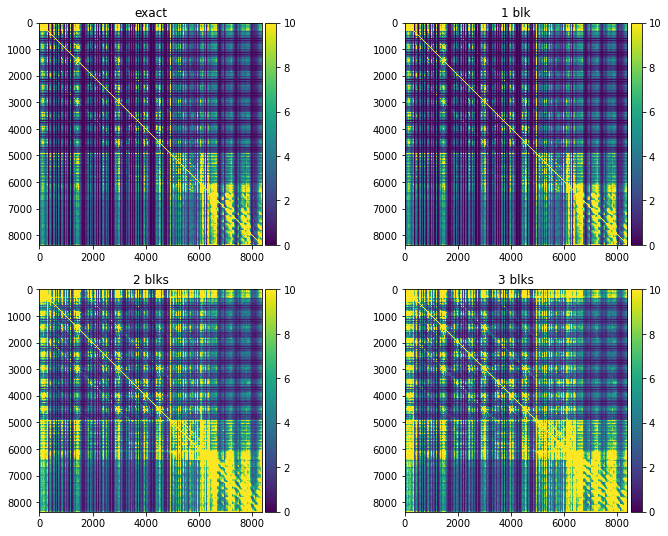

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (12,9))
shw1 = axs[0, 0].imshow(tf.math.abs(tfl.inv(M1)), vmin = 0, vmax = 10)
axs[0, 0].set_title('exact')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw1, cax=cax, orientation='vertical')

shw2 = axs[0, 1].imshow(tf.math.abs(Minv1), vmin = 0, vmax = 10)
axs[0, 1].set_title('1 blk')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw2, cax=cax, orientation='vertical')

shw3 = axs[1, 0].imshow(tf.math.abs(Minv2), vmin = 0, vmax = 10)
axs[1, 0].set_title('2 blks')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw3, cax=cax, orientation='vertical')

shw4 = axs[1, 1].imshow(tf.math.abs(Minv3), vmin = 0, vmax = 10)
axs[1, 1].set_title('3 blks')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw4, cax=cax, orientation='vertical')

#plt.savefig("mat_inv_acc2.pdf", bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots()
shw = axs.imshow(tf.math.abs(M1), vmin = 0, vmax = 0.00005)
#bar = plt.colorbar(shw)
fig.colorbar(shw)
axs.set_title('exact inverse')
plt.show()

In [ ]:
fig, axs = plt.subplots()
shw = axs.imshow(tf.math.abs(ihaar2(haar2(M1))), vmin = 0, vmax = 0.00005)
#bar = plt.colorbar(shw)
fig.colorbar(shw)
axs.set_title('exact inverse')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (12,9))
shw1 = axs[0, 0].imshow(tf.math.abs(cA), vmin = 0, vmax = 0.01)
axs[0, 0].set_title('cA')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw1, cax=cax, orientation='vertical')

shw2 = axs[0, 1].imshow(tf.math.abs(cH), vmin = 0, vmax = 0.01)
axs[0, 1].set_title('cH')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw2, cax=cax, orientation='vertical')

shw3 = axs[1, 0].imshow(tf.math.abs(cV), vmin = 0, vmax = 0.01)
axs[1, 0].set_title('cV')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw3, cax=cax, orientation='vertical')

shw4 = axs[1, 1].imshow(tf.math.abs(cD), vmin = 0, vmax = 0.01)
axs[1, 1].set_title('cD')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw4, cax=cax, orientation='vertical')

#plt.savefig("mat_inv_acc2.pdf", bbox_inches='tight')
plt.show()

In [ ]:
def haar2(block):
    coeffs = pywt.dwt2(block, 'haar')
    cA, (cH, cV, cD) = coeffs
    return tf.concat([tf.concat([cA, cH], 1), tf.concat([cV, cD], 1)], 0)

def ihaar2(block):
    l = int(tf.shape(block)[0].numpy() / 2)
    cA = block[0:l, 0:l]
    cH = block[0:l, l:]
    cV = block[l:, 0:l]
    cD = block[l:, l:]
    return pywt.idwt2((cA, (cH, cV, cD)), 'haar')

def inv_haar(M, size = 1):
    tfl = tf.linalg
    A = haar2(M)
    dim = M.shape[0]
    ls = []
    for i in range(0, dim-size, size):
        ls.append(tfl.inv(A[i:(i+size), i:(i+size)]))
    last_ind = dim % size
    if last_ind == 0:
        last_ind = size
    last_ind = dim - last_ind
    ls.append(tfl.inv(A[last_ind:,last_ind:]))
    A_inv = blockdiag(ls)
    M_inv = ihaar2(A_inv)
    return (M_inv)

In [ ]:
Minv1 = inv_haar(M1, 8366)
Minv2 = inv_haar(M1, 4183)
Minv3 = inv_haar(M1, 2789)

In [ ]:
cA[0:2,4181:]

array([[-0.00035942,  0.00105596],
       [-0.00193345,  0.00302892]], dtype=float32)

In [ ]:
coeffs = pywt.dwt2(M1, 'haar')
cA, (cH, cV, cD) = coeffs

In [ ]:
pywt.idwt2((cA, (cH, cV, cD)), 'haar')

array([[ 3.0941211e-03,  1.2520030e-03,  2.6153377e-03, ...,
        -1.1234160e-04,  1.6141165e-04,  2.4220120e-04],
       [ 1.2520037e-03,  1.0122555e-01,  1.0745076e-02, ...,
        -1.1962571e-03,  1.1621599e-04,  1.5920869e-03],
       [ 2.6153389e-03,  1.0745076e-02,  1.4914371e-01, ...,
        -3.4366953e-03,  3.3834316e-03,  4.5226869e-04],
       ...,
       [-1.1234152e-04, -1.1962571e-03, -3.4366949e-03, ...,
         5.3012755e-04, -1.6031176e-05, -2.1548140e-04],
       [ 1.6141160e-04,  1.1621602e-04,  3.3834316e-03, ...,
        -1.6031176e-05,  6.4447138e-04, -7.4735639e-05],
       [ 2.4220110e-04,  1.5920870e-03,  4.5226852e-04, ...,
        -2.1548140e-04, -7.4735668e-05,  6.5712421e-04]], dtype=float32)

In [ ]:
haar_t = tf.concat([tf.concat([cA, cH], 1), tf.concat([cV, cD], 1)], 0)

In [ ]:
tf.reduce_min(tf.math.abs(tfl.inv(M1)))
tf.reduce_min(M1)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0896237>

In [ ]:
V = tf.random.uniform([1026,1026], -1, 1, dtype = 'float32')
V = tfl.matmul(tf.transpose(V), V)
V_inv = inv_dct(V, 1026)
print(tf.norm(tfl.matmul(V, idct2(tfl.inv(dct2(V)))) - tf.eye(1026, dtype='float32'), ord = 2, axis = [-2,-1]))
print(tf.norm(tfl.matmul(V, V_inv) - tf.eye(1026, dtype='float32'), ord = 2, axis = [-2,-1]))
print(tf.norm(tfl.matmul(V, tfl.inv(V)) - tf.eye(1026, dtype='float32'), ord = 2, axis = [-2,-1]))
print(tf.norm(V_inv - tfl.inv(V), ord = 2, axis = [-2,-1]))
Vinv1_np = tf2np(V_inv)
Vinv_np = tf2np(tfl.inv(V))
print(mean_squared_error(Vinv1_np, Vinv_np))

MSTAR Test

In [ ]:
uploaded = files.upload()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import io
import os
data = zipfile.ZipFile(io.BytesIO(uploaded['data_mstar.zip']), 'r')
data.extractall()

In [ ]:
train_data_dir = '/content/drive/MyDrive/data_mstar/train'
validation_data_dir = '/content/drive/MyDrive/data_mstar/test'

In [ ]:
img_height, img_width=100,100

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=10.,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size= 64,
        class_mode='categorical')

Found 2536 images belonging to 10 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size= 2636,
        class_mode='categorical')

Found 2636 images belonging to 10 classes.


In [ ]:
def reset_seeds():
   np.random.seed(123)
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=2, padding='valid',
                           activation='tanh', input_shape=(100, 100, 3),
                           kernel_initializer=initializers.glorot_uniform(seed=0)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='tanh', kernel_initializer=initializers.glorot_uniform(seed=0)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='tanh', kernel_initializer=initializers.glorot_uniform(seed=0)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='tanh', kernel_initializer=initializers.glorot_uniform(seed=0)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='tanh', kernel_initializer=initializers.glorot_uniform(seed=0)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='tanh', kernel_initializer=initializers.glorot_uniform(seed=0)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, kernel_initializer=initializers.glorot_uniform(seed=0))
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 49, 49, 6)         168       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 6)        0         
 2D)                                                             
                                                                 
 conv2d_29 (Conv2D)          (None, 22, 22, 4)         220       
                                                                 
 conv2d_30 (Conv2D)          (None, 20, 20, 4)         148       
                                                                 
 conv2d_31 (Conv2D)          (None, 18, 18, 4)         148       
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 4)         148       
                                                      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum = 0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# class SaveBatchLoss(tf.keras.callbacks.Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         batch_end_loss.append(logs['loss'])
#         batch_end_acc.append(logs['accuracy'])

batch_end_loss = list()
batch_end_acc = list()

print("Train using Adadelta")
t1_start = time.perf_counter()
model.fit(train_generator, epochs=200, callbacks = SaveBatchLoss(), validation_data = validation_generator)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
model_wrapper = ModelWrapper(tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=CategoricalCrossentropy(from_logits=True),
    solve_method='solve',
    metrics=['accuracy'])

M = list()
N = list()

print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
#history2 = model_wrapper.fit(train_generator, epochs=30, validation_data=validation_generator)
history2 = model_wrapper.fit(train_generator, steps_per_epoch = 5, epochs=20, validation_data=validation_generator)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

In [ ]:
print(sum(N))
print(len(N))
print(sum(N) / len(N))

72.11635922100322
98
0.7358812165408493


In [ ]:
loss1 = model_wrapper.trainer.batch_end_loss
acc1 = model_wrapper.trainer.batch_end_acc

In [ ]:
len(loss1)

4414

In [ ]:
loss1 = batch_end_loss
acc1 = batch_end_acc

In [ ]:
df1 = pd.DataFrame(loss1)
df1.to_csv('loss_adadelta_f_mstar.csv')

In [ ]:
tf.keras.backend.set_floatx("float32")

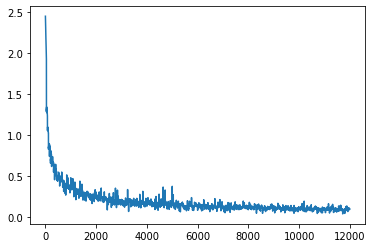

In [ ]:
plt.plot(loss1)
#plt.plot(loss2)

In [ ]:
M1 = M[0]
#M1 = tf.cast(M1, tf.float64)
Minv1 = inv_dct(M1, 8830)
Minv2 = inv_dct(M1, 4415)
Minv3 = inv_dct(M1, 2944)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (12,9))
shw1 = axs[0, 0].imshow(tf.math.abs(tfl.inv(M1)), vmin = 0, vmax = 50)
axs[0, 0].set_title('exact inverse')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw1, cax=cax, orientation='vertical')

shw2 = axs[0, 1].imshow(tf.math.abs(Minv1), vmin = 0, vmax = 50)
axs[0, 1].set_title('1 block')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw2, cax=cax, orientation='vertical')

shw3 = axs[1, 0].imshow(tf.math.abs(Minv2), vmin = 0, vmax = 50)
axs[1, 0].set_title('2 blocks')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw3, cax=cax, orientation='vertical')

shw4 = axs[1, 1].imshow(tf.math.abs(Minv3), vmin = 0, vmax = 50)
axs[1, 1].set_title('3 blocks')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shw4, cax=cax, orientation='vertical')

plt.show()

CIFAR10

In [ ]:
ds = tfds.load('cifar10', as_supervised=True)
std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3))
mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3))

def train_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = tf.image.random_flip_left_right(x)
    x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
    x = tf.image.random_crop(x, (32, 32, 3))
    x = (x - mean) / std
    return x, y

def valid_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = (x - mean) / std
    return x, y

ds['train'] = ds['train'].map(train_prep).shuffle(5000).repeat().batch(5000).prefetch(-1)
ds['test'] = ds['test'].map(valid_prep).batch(10000).prefetch(-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8PWP9E/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8PWP9E/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
def reset_seeds():
   np.random.seed(123)
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=18, kernel_size=3, strides=1, padding='valid',
                           activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])
model.summary()

In [ ]:
def reset_seeds():
   np.random.seed(123)
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
                           activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid',
    #                       activation='relu'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='valid',
    #                       activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.summary()

In [ ]:
def reset_seeds():
   np.random.seed(123)
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
                           activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid',
    #                       activation='relu'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='valid',
    #                       activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.summary()

In [ ]:
def reset_seeds():
   np.random.seed(123)
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid',
                           activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid',
                           activation='relu'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Conv2D(filters=16, kernel_size=1, strides=1, padding='valid',
    #                       activation='relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
    #tf.keras.layers.Softmax()
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# class SaveBatchLoss(tf.keras.callbacks.Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         batch_end_loss.append(logs['loss'])
#         batch_end_acc.append(logs['accuracy'])

batch_end_loss = list()
batch_end_acc = list()

print("Train using Adam")
t1_start = time.perf_counter()
#model.fit(ds['train'], steps_per_epoch = 10, epochs = 600, callbacks = SaveBatchLoss(), validation_data=ds['test'])
history1 = model.fit(ds['train'], steps_per_epoch = 780, epochs = 100, validation_data=ds['test'])
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Adam
Epoch 1/100
780/780 [==============================] - 10s 11ms/step - loss: 1.6636 - accuracy: 0.3916 - val_loss: 1.2498 - val_accuracy: 0.5547
Epoch 2/100
780/780 [==============================] - 11s 14ms/step - loss: 1.2778 - accuracy: 0.5426 - val_loss: 1.1717 - val_accuracy: 0.5825
Epoch 3/100
780/780 [==============================] - 12s 15ms/step - loss: 1.1061 - accuracy: 0.6071 - val_loss: 0.9660 - val_accuracy: 0.6604
Epoch 4/100
780/780 [==============================] - 10s 12ms/step - loss: 1.0136 - accuracy: 0.6427 - val_loss: 0.8786 - val_accuracy: 0.6933
Epoch 5/100
780/780 [==============================] - 9s 11ms/step - loss: 0.9366 - accuracy: 0.6727 - val_loss: 0.8903 - val_accuracy: 0.6883
Epoch 6/100
780/780 [==============================] - 8s 11ms/step - loss: 0.8800 - accuracy: 0.6929 - val_loss: 0.8013 - val_accuracy: 0.7247
Epoch 7/100
780/780 [==============================] - 8s 11ms/step - loss: 0.8372 - accuracy: 0.7088 - val_loss: 0

In [ ]:
model_wrapper = ModelWrapper(tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    solve_method='solve',
    metrics=['accuracy'])

M = list()
N = list()
cond = list()
norm_dif = list()

print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
history2 = model_wrapper.fit(ds['train'], steps_per_epoch = 10, epochs = 100, validation_data = ds['test'])
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

Train using Levenberg-Marquardt
Epoch 1/100


10/10 [==============================] - 39s 2s/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 1.6669 - accuracy: 0.3654 - val_loss: 1.4123 - val_accuracy: 0.4891
Epoch 2/100
10/10 [==============================] - 23s 2s/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 1.3134 - accuracy: 0.5465 - val_loss: 1.2733 - val_accuracy: 0.5764
Epoch 3/100
10/10 [==============================] - 23s 2s/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 1.2126 - accuracy: 0.6036 - val_loss: 1.1792 - val_accuracy: 0.6136
Epoch 4/100
10/10 [==============================] - 23s 2s/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 1.1332 - accuracy: 0.6326 - val_loss: 1.1225 - val_accuracy: 0.6408
Epoch 5/100
10/10 [==============================] - 23s 2s/step - damping_factor: 1.0000e-06 - attempts: 1.0000 - loss: 1.0759 - accuracy: 0.6623 - val_loss: 1.0822 - val_accuracy: 0.6579
Epoch 6/100
10/10 [==============================] - 23s 2s/step - 

In [ ]:
model_wrapper.evaluate(ds['test'])

1/1 [==============================] - 0s 222ms/step - loss: 0.7272 - accuracy: 0.8130


[0.8130000233650208, 0.7271907329559326]

In [ ]:
df = pd.DataFrame(history2.history['loss'])
df.to_csv('train_loss_cnn_alm4.csv')

df = pd.DataFrame(history2.history['val_loss'])
df.to_csv('val_loss_cnn_alm4.csv')

df = pd.DataFrame(history2.history['accuracy'])
df.to_csv('train_acc_cnn_alm4.csv')

df = pd.DataFrame(history2.history['val_accuracy'])
df.to_csv('val_acc_cnn_alm4.csv')

In [ ]:
plt.plot(cond)
plt.xlabel("Number of Iterations", fontsize = 16)
plt.ylabel("Condition Number", fontsize = 16)
plt.savefig("cond_number.pdf")

In [ ]:
plt.plot(norm_dif)
plt.xlabel("Number of Iterations", fontsize = 16)
plt.ylabel("Normalized Norm of Difference", fontsize = 14)
plt.savefig("norm_dif.pdf")

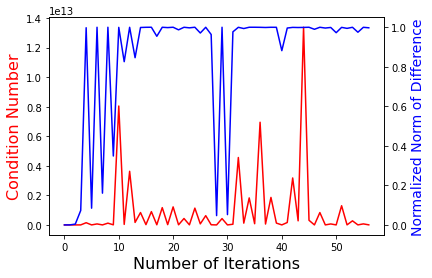

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(cond, color="red")
# set x-axis label
ax.set_xlabel("Number of Iterations", fontsize = 16)
# set y-axis label
ax.set_ylabel("Condition Number",color="red", fontsize=16)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(norm_dif2, color="blue")
ax2.set_ylabel("Normalized Norm of Difference",color="blue",fontsize=14)
#plt.show()
# save the plot as a file
fig.savefig('cond_norm_dif.pdf', bbox_inches='tight')

In [ ]:
print(sum(N))
print(len(N))
print(sum(N) / len(N))

232.4192346090067
594
0.39127817274243554


In [ ]:
loss1 = model_wrapper.trainer.batch_end_loss
acc1 = model_wrapper.trainer.batch_end_acc

In [ ]:
loss1 = batch_end_loss
acc1 = batch_end_acc

In [ ]:
loss1

In [ ]:
M1 = M[1]
t00 = time.perf_counter()
tf.linalg.pinv(M1)
t01 = time.perf_counter()
print(t01 - t00)

t10 = time.perf_counter()
tf.linalg.inv(M1)
t11 = time.perf_counter()
print(t11 - t10)

79.40833260100044
0.8118874739993771


In [ ]:
norm_dif2 = []
for x in norm_dif:
    norm_dif2.append(x/2)

In [ ]:
df1 = pd.DataFrame(norm_dif2)
df1.to_csv('norm_difference.csv')

In [ ]:
res = list()
for i in range(1, 91):
    j = 1000 + 100 * i
    A = tf.random.uniform([j,j], -0.0001, 0.0001)
    A = A + 0.01 * tf.eye(j)
    t_start = time.perf_counter()
    Ainv = tf.linalg.inv(A)
    t_stop = time.perf_counter()
    res.append(t_stop - t_start)

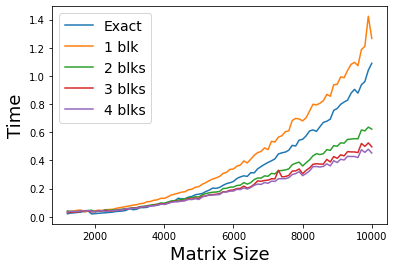

In [ ]:
xax = list()
for i in range(1, 91):
  j = 1000 + 100 * i
  xax.append(j)


plt.plot(xax[1:], res[1:], label='Exact')
plt.plot(xax[1:], res2[1:], label = '1 blk')
plt.plot(xax[1:], res3[1:], label = '2 blks')
plt.plot(xax[1:], res4[1:], label = '3 blks')
plt.plot(xax[1:], res5[1:], label = '4 blks')
plt.legend(fontsize=14)
plt.xlabel("Matrix Size", fontsize = 18)
plt.ylabel("Time", fontsize = 18)
plt.savefig("mat_inv_time.pdf", bbox_inches='tight')

In [ ]:
7814/4

1953.5

RESNET-20 CIFAR-10

In [ ]:
%%capture
!git clone https://github.com/gahaalt/cifar-vs-tensorflow2.git
#!pip install --upgrade tensorflow-gpu

In [ ]:
import os
import logging
logging.getLogger('tensorflow').disabled = True

try:
    os.chdir('cifar-vs-tensorflow2')
except:
    pass

#import numpy as np
#import tensorflow as tf
#import tensorflow_datasets as tfds
#if not tf.test.is_gpu_available():
#    print("GPU is not available, change Runtime!")

#import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
#from tensorflow.keras.utils import plot_model

In [ ]:
ds = tfds.load('cifar10', as_supervised=True)
std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3))
mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3))

def train_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = tf.image.random_flip_left_right(x)
    x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
    x = tf.image.random_crop(x, (32, 32, 3))
    x = (x - mean) / std
    return x, y

def valid_prep(x, y):
    x = tf.cast(x, tf.float32)/255.
    x = (x - mean) / std
    return x, y

ds['train'] = ds['train'].map(train_prep).shuffle(5000).repeat().batch(5000).prefetch(-1)
ds['test'] = ds['test'].map(valid_prep).batch(10000).prefetch(-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteDRF0RG/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteDRF0RG/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
ds_train_numpy = tfds.as_numpy(ds['test'])

In [ ]:
ds_train_numpy.shape()

In [ ]:
from Models.Resnets import cifar_resnet20 as create_model
model = create_model('preactivated', shortcut_type='B')

In [ ]:
#model = create_model('preactivated', shortcut_type='B')
model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=1e-4, group_sizes=(8, 8, 8), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type='B',
                   block_type='preactivated', preact_shortcuts=False)

In [ ]:
model.summary()

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[400, 32000, 48000], values=[0.01, 0.1, 0.01, 0.001])
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[32000], values=[1, 0.1])
#optimizer = tf.keras.optimizers.SGD(schedule, momentum=0.9)
#optimizer = tf.keras.optimizers.Adadelta(1)
optimizer = tf.keras.optimizers.SGD(0.1, momentum=0.9)

model.compile(optimizer, loss_fn, metrics=['accuracy'])

In [ ]:
training_steps = 64000
#training_steps = 128000
validation_interval = 2000

history = model.fit(ds['train'], steps_per_epoch=validation_interval, epochs=training_steps//validation_interval, validation_data=ds['test'])

In [ ]:
#training_steps = 64000
training_steps = 10000
validation_interval = 2000

model.fit(ds['train'], steps_per_epoch=validation_interval, epochs=training_steps//validation_interval, validation_data=ds['test'])

In [ ]:
model_wrapper = ModelWrapper(tf.keras.models.clone_model(model))

schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[199], values=[0.1, 0.3])

model_wrapper.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.3),
    optimizer=tf.keras.optimizers.SGD(schedule),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    jacobian_max_num_rows=20,
    solve_method='solve',
    metrics=['accuracy'])

M = list()
N = list()
cond = list()
norm_dif = list()

print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
history2 = model_wrapper.fit(ds['train'], steps_per_epoch = 20, epochs=50, validation_data=ds['test'])
#history2 = model_wrapper.fit(ds['train'], steps_per_epoch = 3, epochs=5, validation_data=ds['test'])
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

lr = 0.3, 1000 iterations, 50 epochs, 0.2 loss, accuracy 0.91
lr = 0.3, 100 epochs, 0.17 loss, accuracy 0.93
lr = 0.3, 150 epochs, 0.15 loss, accuracy 0.93

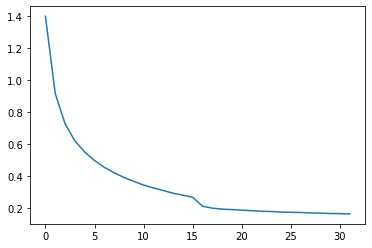

In [ ]:
plt.plot(history.history['loss'])
#plt.savefig("train_loss_cifar10_resnet20_lm.pdf")

In [ ]:
history.history['loss']

In [ ]:
df1 = pd.DataFrame(history2.history['loss'])
df1.to_csv('train_loss_resnet_alm2.csv')

In [ ]:
model_wrapper.evaluate(ds['test'])

1/1 [==============================] - 0s 336ms/step - loss: 0.6872 - accuracy: 0.8234


[0.8234000205993652, 0.6872051954269409]

resnet20
lr = 0.3 for 40 epochs, lr = 0.6 for the last epoch, 0.22 loss, train acc 0.92, test acc 0.859
lr = 0.3, 40 epochs, 0.16 loss, train acc 0.94
lr = 0.3, 60 epochs, 0.10 loss, train acc 0.96
lr = 0.3, 80 epochs, 0.08 loss, train acc 0.97, test acc 0.87
lr = 0.3, 160 epochs, 0.04 loss, train acc 0.98, test acc 0.87
resnet14
alm2blk, 100 epochs, 0.20 loss, train acc 0.93, test acc 0.83

In [ ]:
fig, axs = plt.subplots()
shw = axs.imshow(tf.math.abs(N[10]), vmin = 0, vmax = 0.3)
#bar = plt.colorbar(shw)
fig.colorbar(shw)
axs.set_title('jacobian')
plt.show()

In [ ]:
svd = scipy.linalg.svdvals(N[18])
np.max(svd) / np.min(svd)


68674.37

In [ ]:
len(N)

20

The Original LM Optimizer

In [ ]:
# Copyright (c) 2020 Fabio Di Marco
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# ==============================================================================

import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter

# ==============================================================================


class MeanSquaredError(tf.keras.losses.MeanSquaredError):
    """Provides mean squared error metrics: loss / residuals.
    Use mean squared error for regression problems with one or more outputs.
    """

    def residuals(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return y_true - y_pred


class ReducedOutputsMeanSquaredError(tf.keras.losses.Loss):
    """Provides mean squared error metrics: loss / residuals.
    Consider using this reduced outputs mean squared error loss for regression
    problems with a large number of outputs or at least more then one output.
    This loss function reduces the number of outputs from N to 1, reducing both
    the size of the jacobian matrix and backpropagation complexity.
    Tensorflow, in fact, uses backward differentiation which computational
    complexity is  proportional to the number of outputs.
    """

    def __init__(self,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='reduced_outputs_mean_squared_error'):
        super(ReducedOutputsMeanSquaredError, self).__init__(
            reduction=reduction,
            name=name)

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.math.squared_difference(y_true, y_pred)
        return tf.math.reduce_mean(sq_diff, axis=1)

    def residuals(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.math.squared_difference(y_true, y_pred)
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + tf.math.reduce_mean(sq_diff, axis=1))


"""
    The gauss-newthon algorithm is obtained from the linear approximation of the
    squared residuals and it is used solve least square problems.
    A way to use cross-entropy instead of mean squared error is to compute
    residuals as the square root of the cross-entropy.
"""


class CategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):
    """Provides cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with two or more
    label classes. The labels are expected to be provided in a `one_hot`
    representation.
    """

    def residuals(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + self.fn(y_true, y_pred, **self._fn_kwargs))


class SparseCategoricalCrossentropy(
        tf.keras.losses.SparseCategoricalCrossentropy):
    """Provides cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with two or more
    label classes. The labels are expected to be provided as integers.
    """

    def residuals(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + self.fn(y_true, y_pred, **self._fn_kwargs))


class BinaryCrossentropy(tf.keras.losses.BinaryCrossentropy):
    """Provides cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with only two label
    classes (assumed to be 0 and 1). For each example, there should be a single
    floating-point value per prediction.
    """

    def residuals(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + self.fn(y_true, y_pred, **self._fn_kwargs))


"""
    Other experimental losses for classification problems.
"""


class SquaredCategoricalCrossentropy(tf.keras.losses.Loss):
    """Provides squared cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with two or more
    label classes. The labels are expected to be provided in a `one_hot`
    representation.
    """

    def __init__(self,
                 from_logits=False,
                 label_smoothing=0,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='squared_categorical_crossentropy'):
        super(SquaredCategoricalCrossentropy, self).__init__(
            reduction=reduction,
            name=name)
        self.from_logits = from_logits
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        return tf.math.square(tf.keras.losses.categorical_crossentropy(
            y_true,
            y_pred,
            self.from_logits,
            self.label_smoothing))

    def residuals(self, y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(
            y_true,
            y_pred,
            self.from_logits,
            self.label_smoothing)

    def get_config(self):
        config = {'from_logits': self.from_logits,
                  'label_smoothing': self.label_smoothing}
        base_config = super(SquaredCategoricalCrossentropy, self).get_config()
        return dict(base_config + config)


class CategoricalMeanSquaredError(tf.keras.losses.Loss):
    """Provides mean squared error metrics: loss / residuals.
    Use this categorical mean squared error loss for classification problems
    with two or more label classes. The labels are expected to be provided in a
    `one_hot` representation and the output activation to be softmax.
    """

    def __init__(self,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='categorical_mean_squared_error'):
        super(CategoricalMeanSquaredError, self).__init__(
            reduction=reduction,
            name=name)

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        # Selects the y_pred which corresponds to y_true equal to 1.
        prediction = tf.reduce_sum(tf.math.multiply(y_true, y_pred), axis=1)
        return tf.math.squared_difference(1.0, prediction)

    def residuals(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        # Selects the y_pred which corresponds to y_true equal to 1.
        prediction = tf.reduce_sum(tf.math.multiply(y_true, y_pred), axis=1)
        return 1.0 - prediction


# ==============================================================================


class DampingAlgorithm:
    """Default Levenberg–Marquardt damping algorithm.
    This is used inside the Trainer as a generic class. Many damping algorithms
    can be implemented using the same interface.
    """

    def __init__(self,
                 starting_value=1e-6,
                 dec_factor=0.1,
                 inc_factor=10.0,
                 min_value=1e-6,
                 max_value=1e+10,
                 adaptive_scaling=True,
                 fletcher=False):
        """Initializes `DampingAlgorithm` instance.
        Args:
          starting_value: (Optional) Used to initialize the Trainer internal
            damping_factor.
          dec_factor: (Optional) Used in the train_step decrease the
            damping_factor when new_loss < loss.
          inc_factor: (Optional) Used in the train_step increase the
            damping_factor when new_loss >= loss.
          min_value: (Optional) Used as a lower bound for the damping_factor.
            Higher values improve numerical stability in the resolution of the
            linear system, at the cost of slower convergence.
          max_value: (Optional) Used as an upper bound for the damping_factor,
            and as condition to stop the Training process.
          adaptive_scaling: Bool (Optional) Scales the damping_factor adaptively
            multiplying it with max(diagonal(JJ)).
          fletcher: Bool (Optional) Replace the identity matrix with
            diagonal of the gauss-newton hessian approximation, so that there is
            larger movement along the directions where the gradient is smaller.
            This avoids slow convergence in the direction of small gradient.
        """
        self.starting_value = starting_value
        self.dec_factor = dec_factor
        self.inc_factor = inc_factor
        self.min_value = min_value
        self.max_value = max_value
        self.adaptive_scaling = adaptive_scaling
        self.fletcher = fletcher
        #self.count = 0
        #self.constant = False

    def init_step(self, damping_factor, loss):
        return damping_factor

    def decrease(self, damping_factor, loss):
        # if damping_factor == 1e-6:
        #     self.count = self.count + 1
        # if self.count >= 5:
        #     self.constant = True
        # if self.constant == False:
        #     res = tf.math.maximum(
        #         damping_factor * self.dec_factor,
        #         self.min_value)
        # else:
        #     res = 1e-6
        # return res

        return tf.math.maximum(
            damping_factor * self.dec_factor,
            self.min_value)

    def increase(self, damping_factor, loss):
        # if self.constant == False:
        #     res = tf.math.minimum(
        #         damping_factor * self.inc_factor,
        #         self.max_value)
        # else:
        #     res = 1e-6
        # return res

        return tf.math.minimum(
            damping_factor * self.inc_factor,
            self.max_value)
        #return damping_factor

    def stop_training(self, damping_factor, loss):
        return damping_factor >= self.max_value

    def apply(self, damping_factor, JJ):
        if self.fletcher:
            damping = tf.linalg.tensor_diag(tf.linalg.diag_part(JJ))
        else:
            damping = tf.eye(tf.shape(JJ)[0], dtype=JJ.dtype)

        scaler = 1.0
        if self.adaptive_scaling:
            scaler = tf.math.reduce_max(tf.linalg.diag_part(JJ))

        damping = tf.scalar_mul(scaler * damping_factor, damping)
        return tf.add(JJ, damping)


# ==============================================================================

class Trainer:
    """Levenberg–Marquardt training algorithm.
    """

    def __init__(self,
                 model,
                 optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
                 loss=MeanSquaredError(),
                 damping_algorithm=DampingAlgorithm(),
                 attempts_per_step=10,
                 solve_method='qr',
                 jacobian_max_num_rows=100,
                 experimental_use_pfor=True):
        """Initializes `Trainer` instance.
        Args:
          model: It is the Model to be trained, it is expected to inherit
            from tf.keras.Model and to be already built.
          optimizer: (Optional) Performs the update of the model trainable
            variables. When tf.keras.optimizers.SGD is used it is equivalent
            to the operation `w = w - learning_rate * updates`, where updates is
            the step computed using the Levenberg-Marquardt algorithm.
          loss: (Optional) An object which inherits from tf.keras.losses.Loss
          and have an additional function to compute residuals.
          damping_algorithm: (Optional) Class implementing the damping
            algorithm to use during training.
          attempts_per_step: Integer (Optional) During the train step when new
            model variables are computed, the new loss is evaluated and compared
            with the old loss value. If new_loss < loss, then the new variables
            are accepted, otherwise the old variables are restored and
            new ones are computed using a different damping-factor.
            This argument represents the maximum number of attempts, after which
            the step is taken.
          solve_method: (Optional) Possible values are:
            'qr': Uses QR decomposition which is robust but slower.
            'cholesky': Uses Cholesky decomposition which is fast but may fail
                when the hessian approximation is ill-conditioned.
            'solve': Uses tf.linalg.solve. I don't know what algorithm it
                implements. But it seems a compromise in terms of speed and
                robustness.
          jacobian_max_num_rows: Integer (Optional) When the number of residuals
            is greater then the number of variables (overdetermined), the
            hessian approximation is computed by slicing the input and
            accumulate the result of each computation. In this way it is
            possible to drastically reduce the memory usage and increase the
            speed as well. The input is sliced into blocks of size less than or
            equal to the jacobian_max_num_rows.
          experimental_use_pfor: (Optional) If true, vectorizes the jacobian
            computation. Else falls back to a sequential while_loop.
            Vectorization can sometimes fail or lead to excessive memory usage.
            This option can be used to disable vectorization in such cases.
        """
        if not model.built:
            raise ValueError('Trainer model has not yet been built. '
                             'Build the model first by calling `build()` or '
                             'calling `fit()` with some data, or specify an '
                             '`input_shape` argument in the first layer(s) for '
                             'automatic build.')

        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.damping_algorithm = damping_algorithm
        self.attempts_per_step = attempts_per_step
        self.jacobian_max_num_rows = jacobian_max_num_rows
        self.experimental_use_pfor = experimental_use_pfor
        self.batch_end_loss = list()
        self.batch_end_acc = list()

        # Define and select linear system equation solver.
        def qr(matrix, rhs):
            q, r = tf.linalg.qr(matrix, full_matrices=True)
            y = tf.linalg.matmul(q, rhs, transpose_a=True)
            return tf.linalg.triangular_solve(r, y, lower=False)

        def cholesky(matrix, rhs):
            chol = tf.linalg.cholesky(matrix)
            return tf.linalg.cholesky_solve(chol, rhs)

        def solve(matrix, rhs):
            return tf.linalg.solve(matrix, rhs)

        if solve_method == 'qr':
            self.solve_function = qr
        elif solve_method == 'cholesky':
            self.solve_function = cholesky
        elif solve_method == 'solve':
            self.solve_function = solve
        else:
            raise ValueError('Invalid solve_method.')

        # Keep track of the current damping_factor.
        self.damping_factor = tf.Variable(
            self.damping_algorithm.starting_value,
            trainable=False,
            dtype=self.model.dtype)

        # Used to backup and restore model variables.
        self._backup_variables = []

        # Since training updates are computed with shape (num_variables, 1),
        # self._splits and self._shapes are needed to split and reshape the
        # updates so that they can be applied to the model trainable_variables.
        self._splits = []
        self._shapes = []

        for variable in self.model.trainable_variables:
            variable_shape = tf.shape(variable)
            variable_size = tf.reduce_prod(variable_shape)
            backup_variable = tf.Variable(
                tf.zeros_like(variable),
                trainable=False)

            self._backup_variables.append(backup_variable)
            self._splits.append(variable_size)
            self._shapes.append(variable_shape)

        self._num_variables = tf.reduce_sum(self._splits).numpy().item()
        self._num_outputs = None

    @tf.function
    def _compute_jacobian(self, inputs, targets):
        with tf.GradientTape(persistent=True) as tape:
            outputs = self.model(inputs, training=True)
            residuals = self.loss.residuals(targets, outputs)

        #print(len(self.model.trainable_variables))

        jacobians = tape.jacobian(
            residuals,
            self.model.trainable_variables,
            experimental_use_pfor=self.experimental_use_pfor,
            #parallel_iterations=20,
            unconnected_gradients=tf.UnconnectedGradients.ZERO)

        del tape

        num_residuals = tf.reduce_prod(tf.shape(residuals))
        jacobians = [tf.reshape(j, (num_residuals, -1)) for j in jacobians]
        jacobian = tf.concat(jacobians, axis=1)
        residuals = tf.reshape(residuals, (num_residuals, -1))

        return jacobian, residuals, outputs

    def _init_gauss_newton_overdetermined(self, inputs, targets):
        # Perform the following computation:
        # J, residuals, outputs = self._compute_jacobian(inputs, targets)
        # JJ = tf.linalg.matmul(J, J, transpose_a=True)
        # rhs = tf.linalg.matmul(J, residuals, transpose_a=True)
        #
        # But reduce memory usage by slicing the inputs so that the jacobian
        # matrix will have maximum shape (jacobian_max_num_rows, num_variables)
        # instead of (batch_size, num_variables).
        slice_size = self.jacobian_max_num_rows // self._num_outputs
        batch_size = tf.shape(inputs)[0]
        num_slices = batch_size // slice_size
        remainder = batch_size % slice_size

        JJ = tf.zeros(
            [self._num_variables, self._num_variables],
            dtype=self.model.dtype)

        rhs = tf.zeros(
            [self._num_variables, 1],
            dtype=self.model.dtype)

        outputs_array = tf.TensorArray(
            self.model.dtype, size=0, dynamic_size=True)

        for i in tf.range(num_slices):
            tf.autograph.experimental.set_loop_options(
                shape_invariants=[
                    (rhs, tf.TensorShape((self._num_variables, None)))])

            _inputs = inputs[i * slice_size:(i + 1) * slice_size]
            _targets = targets[i * slice_size:(i + 1) * slice_size]

            #print('computing jacobian...')

            J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)

            outputs_array = outputs_array.write(i, _outputs)

            JJ += tf.linalg.matmul(J, J, transpose_a=True)
            rhs += tf.linalg.matmul(J, residuals, transpose_a=True)

        if remainder > 0:
            _inputs = inputs[num_slices * slice_size::]
            _targets = targets[num_slices * slice_size::]

            J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)

            if num_slices > 0:
                outputs = tf.concat([outputs_array.concat(), _outputs], axis=0)
            else:
                outputs = _outputs

            JJ += tf.linalg.matmul(J, J, transpose_a=True)
            rhs += tf.linalg.matmul(J, residuals, transpose_a=True)
        else:
            outputs = outputs_array.concat()

        return 0.0, JJ, rhs, outputs

    def _init_gauss_newton_underdetermined(self, inputs, targets):
        slice_size = self.jacobian_max_num_rows // self._num_outputs
        batch_size = tf.shape(inputs)[0]
        num_slices = batch_size // slice_size

        #print(num_slices)
        remainder = batch_size % slice_size

        #num_residuals = batch_size * self._num_outputs #caution

        outputs_array = tf.TensorArray(
            self.model.dtype, size=0, dynamic_size=True)

        # JJ_array = tf.TensorArray(
        #     self.model.dtype, size=0, dynamic_size=True)

        rhs_array = tf.TensorArray(
            self.model.dtype, size=0, dynamic_size=True)

        for i in tf.range(num_slices):

            # _JJ_array = tf.TensorArray(
            #     self.model.dtype, size=0, dynamic_size=True)

            _inputs_i = inputs[i * slice_size:(i + 1) * slice_size]
            _targets_i = targets[i * slice_size:(i + 1) * slice_size]

            if i == 0:
                J, residuals_i, _outputs_i = self._compute_jacobian(_inputs_i, _targets_i)
            else:
                J_i, residuals_i, _outputs_i = self._compute_jacobian(_inputs_i, _targets_i)
                J = tf.concat([J, J_i], 0)

            #J_i, residuals_i, _outputs_i = self._compute_jacobian(_inputs_i, _targets_i)
            outputs_array = outputs_array.write(i, _outputs_i)
            rhs_array = rhs_array.write(i, residuals_i)

            # for j in tf.range(num_slices): #caution
            #     # tf.autograph.experimental.set_loop_options(
            #     #     shape_invariants=[
            #     #         (rhs, tf.TensorShape((batch_size, None)) ) ]) #caution

            #     _inputs_j = inputs[j * slice_size:(j + 1) * slice_size]
            #     _targets_j = targets[j * slice_size:(j + 1) * slice_size]
            #     J_j, residuals_j, _outputs_j = self._compute_jacobian(_inputs_j, _targets_j)
            #     _JJ_array = _JJ_array.write(j, tf.transpose( tf.linalg.matmul(J_i, J_j, transpose_b=True) ) )

            #JJ_list.append(tf.concat(_JJ_list, 1))
            #print('concatenating jacobian by row...')
            #_JJ = tf.transpose( _JJ_array.concat() )
            #JJ_array = JJ_array.write(i, _JJ)

        #print('concatenating jacobian by column...')
        #JJ = JJ_array.concat()
        JJ = tf.linalg.matmul(J, J, transpose_b=True)
        rhs = rhs_array.concat()
        outputs = outputs_array.concat()

        # if remainder > 0: #caution, remainder has to be 0 now
        #     _inputs = inputs[num_slices * slice_size::]
        #     _targets = targets[num_slices * slice_size::]

        #     J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)

        #     if num_slices > 0:
        #         outputs = tf.concat([outputs_array.concat(), _outputs], axis=0)
        #     else:
        #         outputs = _outputs

        #     JJ += tf.linalg.matmul(J, J, transpose_a=True)
        #     rhs += tf.linalg.matmul(J, residuals, transpose_a=True)
        # else:

        # return JJ, rhs, outputs, inputs, targets
        return J, JJ, rhs, outputs

    def dct2(self, block):
        return tf.signal.dct(tf.transpose(tf.signal.dct(tf.transpose(block), norm='ortho')), norm='ortho')

    def idct2(self, block):
        return tf.signal.idct(tf.transpose(tf.signal.idct(tf.transpose(block), norm='ortho')), norm='ortho')

    def blockdiag(self, blocks):
        tfl = tf.linalg
        #linop_blocks = [tfl.LinearOperatorFullMatrix(block) for block in blocks]
        #linop_block_diagonal = tfl.LinearOperatorBlockDiag(linop_blocks)
        return tfl.LinearOperatorBlockDiag([tfl.LinearOperatorFullMatrix(block) for block in blocks]).to_dense()

    def inv_dct(self, M, size = 1):
        tfl = tf.linalg
        A = self.dct2(M)
        dim = M.shape[0]
        ls = []
        #inv_start = time.perf_counter()
        for i in range(0, dim-size, size):
            ls.append(tfl.inv(A[i:(i+size), i:(i+size)]))
        last_ind = dim % size
        if last_ind == 0:
            last_ind = size
        last_ind = dim - last_ind
        ls.append(tfl.inv(A[last_ind:,last_ind:]))
        del A
        #inv_end = time.perf_counter()
        #T.append(inv_end - inv_start)
        A_inv = self.blockdiag(ls)
        del ls
        #M_inv = self.idct2(A_inv)
        return self.idct2(A_inv)

    def haar2(self, block):
        coeffs = pywt.dwt2(block, 'haar')
        cA, (cH, cV, cD) = coeffs
        return tf.concat([tf.concat([cA, cH], 1), tf.concat([cV, cD], 1)], 0)

    def ihaar2(self, block):
        l = int(tf.shape(block)[0].numpy() / 2)
        cA = block[0:l, 0:l]
        cH = block[0:l, l:]
        cV = block[l:, 0:l]
        cD = block[l:, l:]
        return pywt.idwt2((cA, (cH, cV, cD)), 'haar')

    def inv_haar(self, M, size = 1):
        tfl = tf.linalg
        A = self.haar2(M)
        dim = M.shape[0]
        ls = []
        for i in range(0, dim-size, size):
            ls.append(tfl.inv(A[i:(i+size), i:(i+size)]))
        last_ind = dim % size
        if last_ind == 0:
            last_ind = size
        last_ind = dim - last_ind
        ls.append(tfl.inv(A[last_ind:,last_ind:]))
        A_inv = self.blockdiag(ls)
        M_inv = self.ihaar2(A_inv)
        return M_inv

###########################
######## Here!!!! #########
###########################

    def _compute_gauss_newton_overdetermined(self, J, JJ, rhs): #here!!
        updates = self.solve_function(JJ, rhs)
        #updates = tf.linalg.matmul(self.inv_dct(JJ, 2000), rhs)

        # if (len(M) >= 10):

        #     M.pop(0)
        #M.append(JJ)

        #tt_start = time.perf_counter()
        #jjinv = self.inv_dct(JJ, 4415) #mstar 8830
        #jjinv = self.inv_dct(JJ, 2789) #mnist 8366
        #jjinv = self.inv_dct(JJ, 1954) #cifar 7814
        #jjinv = tf.linalg.inv(JJ)

        #tt_stop = time.perf_counter()
        #updates = tf.linalg.matmul(jjinv, rhs)
        #N.append(tt_stop - tt_start)

        # svd = scipy.linalg.svdvals(JJ)
        # cond.append(np.max(svd) / np.min(svd) )

        # jjinv1_np = tf2np(inv_dct(JJ, 7814) ) #cifar 7814
        # jjinv_np = tf2np(jjinv)
        # num = np.linalg.norm(jjinv_np - jjinv1_np)
        # denom = np.linalg.norm((jjinv_np + jjinv1_np) / 2)
        # norm_dif.append(num / denom)

        #return tf.linalg.matmul(tf.linalg.inv(JJ), rhs)
        return updates

    def _compute_gauss_newton_underdetermined(self, J, JJ, rhs):
        # JJinv_e = self.solve_function(JJ, rhs)
        # slice_size = self.jacobian_max_num_rows // self._num_outputs
        # batch_size = tf.shape(inputs)[0]
        # num_slices = batch_size // slice_size
        # #print(num_slices)
        # remainder = batch_size % slice_size
        # #num_residuals = batch_size * self._num_outputs #caution

        # # JJ = tf.zeros(
        # #     [self._num_variables, self._num_variables],
        # #     dtype=self.model.dtype)

        # updates = tf.zeros(
        #      [self._num_variables, 1], #caution
        #      dtype=self.model.dtype)

        # for i in tf.range(num_slices):
        #     tf.autograph.experimental.set_loop_options(
        #         shape_invariants=[
        #             (updates, tf.TensorShape((self._num_variables, None)) ) ]) #caution

        #     _inputs = inputs[i * slice_size:(i + 1) * slice_size]
        #     _targets = targets[i * slice_size:(i + 1) * slice_size]
        #     _JJinv_e = JJinv_e[i * slice_size:(i + 1) * slice_size]

        #     J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)

        #     updates += tf.linalg.matmul(J, _JJinv_e, transpose_a=True)

        #updates = self.solve_function(JJ, rhs)
        jjinv = self.inv_dct(JJ, 1250) #cifar 5000
        updates = tf.linalg.matmul(jjinv, rhs)

        # if (len(N) >= 20):
        #     N.pop(0)
        # N.append(JJ)
        #updates = tf.linalg.matmul(self.inv_dct(JJ, 1334), rhs)
        updates = tf.linalg.matmul(J, updates, transpose_a=True)

        return updates

    def _train_step(self, inputs, targets,
                    init_gauss_newton, compute_gauss_newton):
        # J: jacobian matrix not used in the overdetermined case.
        # JJ: gauss-newton hessian approximation
        # rhs: gradient when overdetermined, residuals when underdetermined.
        # outputs: prediction of the model for the current inputs.
        J, JJ, rhs, outputs = init_gauss_newton(inputs, targets)

        # Perform normalization for numerical stability.
        batch_size = tf.shape(inputs)[0]
        normalization_factor = 1.0 / tf.dtypes.cast(
            batch_size,
            dtype=self.model.dtype)

        JJ *= normalization_factor
        rhs *= normalization_factor

        # Compute the current loss value.
        loss = self.loss(targets, outputs)

        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))

            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        loss = new_loss
                        damping_factor = self.damping_algorithm.decrease(
                            damping_factor, loss)
                        self.backup_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break

        # Update the damping_factor which will be used in the next train_step.
        self.damping_factor.assign(damping_factor)
        return loss, outputs, attempt, stop_training

    def _compute_num_outputs(self, inputs, targets):
        input_shape = inputs.shape[1::]
        target_shape = targets.shape[1::]
        _inputs = tf.keras.Input(shape=input_shape,
                                 dtype=inputs.dtype)
        _targets = tf.keras.Input(shape=target_shape,
                                  dtype=targets.dtype)
        outputs = self.model(_inputs)
        residuals = self.loss.residuals(_targets, outputs)
        return tf.reduce_prod(residuals.shape[1::])

    def reset_damping_factor(self):
        self.damping_factor.assign(self.damping_algorithm.starting_value)

    def backup_variables(self):
        zip_args = (self.model.trainable_variables, self._backup_variables)
        for variable, backup in zip(*zip_args):
            backup.assign(variable)

    def restore_variables(self):
        zip_args = (self.model.trainable_variables, self._backup_variables)
        for variable, backup in zip(*zip_args):
            variable.assign(backup)

    def train_step(self, inputs, targets):
        if self._num_outputs is None:
            self._num_outputs = self._compute_num_outputs(inputs, targets)

        batch_size = tf.shape(inputs)[0]
        num_residuals = batch_size * self._num_outputs
        overdetermined = num_residuals >= self._num_variables

        if overdetermined:
            loss, outputs, attempts, stop_training = self._train_step(
                inputs,
                targets,
                self._init_gauss_newton_overdetermined,
                self._compute_gauss_newton_overdetermined)
        else:
            loss, outputs, attempts, stop_training = self._train_step(
                inputs,
                targets,
                #self._init_gauss_newton_overdetermined,
                #self._compute_gauss_newton_overdetermined)
                self._init_gauss_newton_underdetermined,
                self._compute_gauss_newton_underdetermined)
        self.batch_end_loss.append(loss)

        return loss, outputs, attempts, stop_training

    def test_step(self, inputs, targets):
        outputs = self.model(inputs, training=False)
        loss = self.loss(targets, outputs)

        return loss, outputs

    def fit(self, dataset, epochs=1, metrics=None, validation_data=None):
        """Trains self.model on the dataset for a fixed number of epochs.
        Arguments:
            dataset: A `tf.data` dataset, must return a tuple (inputs, targets).
            epochs: Integer. Number of epochs to train the model.
            metrics: List of metrics to be evaluated during training.
            validation_data: A `tf.data` dataset, must return a tuple
            (inputs, targets).
        """
        self.backup_variables()
        steps = dataset.cardinality().numpy().item()
        stop_training = False

        if metrics is None:
            metrics = []

        pl = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps',
            stateful_metrics=["damping_factor", "attempts"])

        pl.set_params(
            {"verbose": 1, "epochs": epochs, "steps": steps})

        pl.on_train_begin()

        for epoch in range(epochs):
            if stop_training:
                break

            # Reset metrics.
            for m in metrics:
                m.reset_states()

            pl.on_epoch_begin(epoch)

            iterator = iter(dataset)

            for step in range(steps):
                if stop_training:
                    break

                pl.on_train_batch_begin(step)

                data = next(iterator)

                data = data_adapter.expand_1d(data)
                inputs, targets, sample_weight = \
                    data_adapter.unpack_x_y_sample_weight(data)

                loss, outputs, attempts, stop_training = \
                    self.train_step(inputs, targets)

                # Update metrics.
                for m in metrics:
                    m.update_state(targets, outputs)

                logs = {"damping_factor": self.damping_factor,
                        "attempts": attempts,
                        "loss": loss}
                logs.update({m.name: m.result() for m in metrics})

                pl.on_train_batch_end(step, logs)

            if validation_data:

                validation_data = data_adapter.expand_1d(validation_data)
                val_inputs, val_targets, val_sample_weight = \
                    data_adapter.unpack_x_y_sample_weight(validation_data)
                val_loss, val_outputs = self.test_step(val_inputs, val_targets)
                for m in metrics:
                    m.reset_states()
                    m.update_state(val_targets, val_outputs)
                logs.update({"val_loss" : val_loss})
                logs.update({"val_" + m.name: m.result() for m in metrics})

            pl.on_epoch_end(epoch)

        pl.on_train_end()


# ==============================================================================


class ModelWrapper(tf.keras.Sequential):
    """Wraps a keras model.
    When fit is called, the wrapped model is trained using Levenberg–Marquardt.
    """

    def __init__(self, model):
        if not model.built:
            raise ValueError('This model has not yet been built. '
                             'Build the model first by calling `build()` or '
                             'calling `fit()` with some data, or specify an '
                             '`input_shape` argument in the first layer(s) for '
                             'automatic build.')

        super(ModelWrapper, self).__init__([model])
        self.model = model
        self.trainer = None

    def compile(self,
                optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
                loss=MeanSquaredError(),
                damping_algorithm=DampingAlgorithm(),
                attempts_per_step=8,
                solve_method='qr',
                jacobian_max_num_rows=20,
                experimental_use_pfor=True,
                metrics=None,
                loss_weights=None,
                weighted_metrics=None,
                **kwargs):
        super(ModelWrapper, self).compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics,
            loss_weights=loss_weights,
            weighted_metrics=weighted_metrics,
            run_eagerly=True)

        self.trainer = Trainer(
            model=self.model,
            optimizer=optimizer,
            loss=loss,
            damping_algorithm=damping_algorithm,
            attempts_per_step=attempts_per_step,
            solve_method=solve_method,
            jacobian_max_num_rows=jacobian_max_num_rows,
            experimental_use_pfor=experimental_use_pfor)

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        inputs, targets, sample_weight = \
            data_adapter.unpack_x_y_sample_weight(data)

        loss, outputs, attempts, stop_training = \
            self.trainer.train_step(inputs, targets)

        self.compiled_metrics.update_state(targets, outputs)

        logs = {"damping_factor": self.trainer.damping_factor,
                "attempts": attempts,
                "loss": loss}
        logs.update({m.name: m.result() for m in self.metrics})

        # BUG: In tensorflow v2.2.0 and v2.3.0 setting model.stop_training=True
        # does not stop training immediately, but only at the end of the epoch.
        # https://github.com/tensorflow/tensorflow/issues/41174
        self.stop_training = stop_training
        self.trainer.batch_end_acc.append(logs['accuracy'])

        return logs

    def test_step(self, data):
        data = data_adapter.expand_1d(data)
        val_inputs, val_targets, val_sample_weight = \
            data_adapter.unpack_x_y_sample_weight(data)

        val_outputs = self.model(val_inputs, training=False)
        val_loss = self.trainer.loss(val_targets, val_outputs)

        #val_loss, val_outputs = \
        #    self.trainer.test_step(val_inputs, val_targets)

        self.compiled_metrics.update_state(val_targets, val_outputs)

        logs = {"loss" : val_loss}
        logs.update({m.name: m.result() for m in self.metrics})

        return logs

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_data=None,
            **kwargs):
        if verbose > 0:
            if callbacks is None:
                callbacks = []

            callbacks.append(tf.keras.callbacks.ProgbarLogger(
                count_mode='steps',
                stateful_metrics=["damping_factor", "attempts"]))

        return super(ModelWrapper, self).fit(
            x=x,
            y=y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            validation_data=validation_data,
            **kwargs)

In [ ]:
import os
import tensorflow as tf


def regularized_padded_conv(*args, **kwargs):
    return tf.keras.layers.Conv2D(*args, **kwargs, padding='same', kernel_regularizer=_regularizer,
                                  kernel_initializer='he_normal', use_bias=False)


def bn_relu(x):
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)


def shortcut(x, filters, stride, mode):
    if x.shape[-1] == filters:
        return x
    elif mode == 'B':
        return regularized_padded_conv(filters, 1, strides=stride)(x)
    elif mode == 'B_original':
        x = regularized_padded_conv(filters, 1, strides=stride)(x)
        return tf.keras.layers.BatchNormalization()(x)
    elif mode == 'A':
        return tf.pad(tf.keras.layers.MaxPool2D(1, stride)(x) if stride>1 else x,
                      paddings=[(0, 0), (0, 0), (0, 0), (0, filters - x.shape[-1])])
    else:
        raise KeyError("Parameter shortcut_type not recognized!")


def original_block(x, filters, stride=1, **kwargs):
    c1 = regularized_padded_conv(filters, 3, strides=stride)(x)
    c2 = regularized_padded_conv(filters, 3)(bn_relu(c1))
    c2 = tf.keras.layers.BatchNormalization()(c2)

    mode = 'B_original' if _shortcut_type == 'B' else _shortcut_type
    x = shortcut(x, filters, stride, mode=mode)
    return tf.keras.layers.ReLU()(x + c2)


def preactivation_block(x, filters, stride=1, preact_block=False):
    flow = bn_relu(x)
    if preact_block:
        x = flow

    c1 = regularized_padded_conv(filters, 3, strides=stride)(flow)
    if _dropout:
        c1 = tf.keras.layers.Dropout(_dropout)(c1)

    c2 = regularized_padded_conv(filters, 3)(bn_relu(c1))
    x = shortcut(x, filters, stride, mode=_shortcut_type)
    return x + c2


def bootleneck_block(x, filters, stride=1, preact_block=False):
    flow = bn_relu(x)
    if preact_block:
        x = flow

    c1 = regularized_padded_conv(filters//_bootleneck_width, 1)(flow)
    c2 = regularized_padded_conv(filters//_bootleneck_width, 3, strides=stride)(bn_relu(c1))
    c3 = regularized_padded_conv(filters, 1)(bn_relu(c2))
    x = shortcut(x, filters, stride, mode=_shortcut_type)
    return x + c3


def group_of_blocks(x, block_type, num_blocks, filters, stride, block_idx=0):
    global _preact_shortcuts
    preact_block = True if _preact_shortcuts or block_idx == 0 else False

    x = block_type(x, filters, stride, preact_block=preact_block)
    for i in range(num_blocks-1):
        x = block_type(x, filters)
    return x


def Resnet(input_shape, n_classes, l2_reg=1e-4, group_sizes=(2, 2, 2), features=(16, 32, 64), strides=(1, 2, 2),
           shortcut_type='B', block_type='preactivated', first_conv={"filters": 16, "kernel_size": 3, "strides": 1},
           dropout=0, cardinality=1, bootleneck_width=4, preact_shortcuts=True):

    global _regularizer, _shortcut_type, _preact_projection, _dropout, _cardinality, _bootleneck_width, _preact_shortcuts
    _bootleneck_width = bootleneck_width # used in ResNeXts and bootleneck blocks
    _regularizer = tf.keras.regularizers.l2(l2_reg)
    _shortcut_type = shortcut_type # used in blocks
    _cardinality = cardinality # used in ResNeXts
    _dropout = dropout # used in Wide ResNets
    _preact_shortcuts = preact_shortcuts

    block_types = {'preactivated': preactivation_block,
                   'bootleneck': bootleneck_block,
                   'original': original_block}

    selected_block = block_types[block_type]
    inputs = tf.keras.layers.Input(shape=input_shape)
    flow = regularized_padded_conv(**first_conv)(inputs)

    if block_type == 'original':
        flow = bn_relu(flow)

    for block_idx, (group_size, feature, stride) in enumerate(zip(group_sizes, features, strides)):
        flow = group_of_blocks(flow,
                               block_type=selected_block,
                               num_blocks=group_size,
                               block_idx=block_idx,
                               filters=feature,
                               stride=stride)

    if block_type != 'original':
        flow = bn_relu(flow)

    flow = tf.keras.layers.GlobalAveragePooling2D()(flow)
    outputs = tf.keras.layers.Dense(n_classes, kernel_regularizer=_regularizer)(flow)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def load_weights_func(model, model_name):
    try: model.load_weights(os.path.join('saved_models', model_name + '.tf'))
    except tf.errors.NotFoundError: print("No weights found for this model!")
    return model


def cifar_resnet20(block_type='original', shortcut_type='A', l2_reg=1e-4, load_weights=False):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(3, 3, 3), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, preact_shortcuts=False)
    if load_weights: model = load_weights_func(model, 'cifar_resnet20')
    return model


def cifar_resnet32(block_type='original', shortcut_type='A', l2_reg=1e-4, load_weights=False):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(5, 5, 5), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, preact_shortcuts=False)
    if load_weights: model = load_weights_func(model, 'cifar_resnet32')
    return model


def cifar_resnet44(block_type='original', shortcut_type='A', l2_reg=1e-4, load_weights=False):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(7, 7, 7), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, preact_shortcuts=False)
    if load_weights: model = load_weights_func(model, 'cifar_resnet44')
    return model


def cifar_resnet56(block_type='original', shortcut_type='A', l2_reg=1e-4, load_weights=False):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(9, 9, 9), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, preact_shortcuts=False)
    if load_weights: model = load_weights_func(model, 'cifar_resnet56')
    return model


def cifar_resnet110(block_type='preactivated', shortcut_type='B', l2_reg=1e-4, load_weights=False):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(18, 18, 18), features=(16, 32, 64),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, preact_shortcuts=False)
    if load_weights: model = load_weights_func(model, 'cifar_resnet110')
    return model


def cifar_resnet164(shortcut_type='B', load_weights=False, l2_reg=1e-4):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(18, 18, 18), features=(64, 128, 256),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type='bootleneck', preact_shortcuts=True)
    if load_weights: model = load_weights_func(model, 'cifar_resnet164')
    return model


def cifar_resnet1001(shortcut_type='B', load_weights=False, l2_reg=1e-4):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(111, 111, 111), features=(64, 128, 256),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type='bootleneck', preact_shortcuts=True)
    if load_weights: model = load_weights_func(model, 'cifar_resnet1001')
    return model


def cifar_wide_resnet(N, K, block_type='preactivated', shortcut_type='B', dropout=0, l2_reg=2.5e-4):
    assert (N-4) % 6 == 0, "N-4 has to be divisible by 6"
    lpb = (N-4) // 6 # layers per block - since N is total number of convolutional layers in Wide ResNet
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(lpb, lpb, lpb), features=(16*K, 32*K, 64*K),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type=block_type, dropout=dropout, preact_shortcuts=True)
    return model


def cifar_WRN_16_4(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(16, 4, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_16_4')
    return model


def cifar_WRN_40_4(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(40, 4, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_40_4')
    return model


def cifar_WRN_16_8(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(16, 8, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_16_8')
    return model


def cifar_WRN_28_10(shortcut_type='B', load_weights=False, dropout=0, l2_reg=2.5e-4):
    model = cifar_wide_resnet(28, 10, 'preactivated', shortcut_type, dropout=dropout, l2_reg=l2_reg)
    if load_weights: model = load_weights_func(model, 'cifar_WRN_28_10')
    return model


def cifar_resnext(N, cardinality, width, shortcut_type='B',):
    assert (N-3) % 9 == 0, "N-4 has to be divisible by 6"
    lpb = (N-3) // 9 # layers per block - since N is total number of convolutional layers in Wide ResNet
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=1e-4, group_sizes=(lpb, lpb, lpb), features=(16*width, 32*width, 64*width),
                   strides=(1, 2, 2), first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, shortcut_type=shortcut_type,
                   block_type='resnext', cardinality=cardinality, width=width)
    return model

The LM with line search

In [ ]:
# Copyright (c) 2020 Fabio Di Marco
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# ==============================================================================

import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter

# ==============================================================================


class MeanSquaredError(tf.keras.losses.MeanSquaredError):
    """Provides mean squared error metrics: loss / residuals.
    Use mean squared error for regression problems with one or more outputs.
    """

    def residuals(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return y_true - y_pred


class ReducedOutputsMeanSquaredError(tf.keras.losses.Loss):
    """Provides mean squared error metrics: loss / residuals.
    Consider using this reduced outputs mean squared error loss for regression
    problems with a large number of outputs or at least more then one output.
    This loss function reduces the number of outputs from N to 1, reducing both
    the size of the jacobian matrix and backpropagation complexity.
    Tensorflow, in fact, uses backward differentiation which computational
    complexity is  proportional to the number of outputs.
    """

    def __init__(self,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='reduced_outputs_mean_squared_error'):
        super(ReducedOutputsMeanSquaredError, self).__init__(
            reduction=reduction,
            name=name)

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.math.squared_difference(y_true, y_pred)
        return tf.math.reduce_mean(sq_diff, axis=1)

    def residuals(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.math.squared_difference(y_true, y_pred)
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + tf.math.reduce_mean(sq_diff, axis=1))


"""
    The gauss-newthon algorithm is obtained from the linear approximation of the
    squared residuals and it is used solve least square problems.
    A way to use cross-entropy instead of mean squared error is to compute
    residuals as the square root of the cross-entropy.
"""


class CategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):
    """Provides cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with two or more
    label classes. The labels are expected to be provided in a `one_hot`
    representation.
    """

    def residuals(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + self.fn(y_true, y_pred, **self._fn_kwargs))


class SparseCategoricalCrossentropy(
        tf.keras.losses.SparseCategoricalCrossentropy):
    """Provides cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with two or more
    label classes. The labels are expected to be provided as integers.
    """

    def residuals(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + self.fn(y_true, y_pred, **self._fn_kwargs))


class BinaryCrossentropy(tf.keras.losses.BinaryCrossentropy):
    """Provides cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with only two label
    classes (assumed to be 0 and 1). For each example, there should be a single
    floating-point value per prediction.
    """

    def residuals(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        return tf.math.sqrt(eps + self.fn(y_true, y_pred, **self._fn_kwargs))


"""
    Other experimental losses for classification problems.
"""


class SquaredCategoricalCrossentropy(tf.keras.losses.Loss):
    """Provides squared cross-entropy metrics: loss / residuals.
    Use this cross-entropy loss for classification problems with two or more
    label classes. The labels are expected to be provided in a `one_hot`
    representation.
    """

    def __init__(self,
                 from_logits=False,
                 label_smoothing=0,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='squared_categorical_crossentropy'):
        super(SquaredCategoricalCrossentropy, self).__init__(
            reduction=reduction,
            name=name)
        self.from_logits = from_logits
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        return tf.math.square(tf.keras.losses.categorical_crossentropy(
            y_true,
            y_pred,
            self.from_logits,
            self.label_smoothing))

    def residuals(self, y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(
            y_true,
            y_pred,
            self.from_logits,
            self.label_smoothing)

    def get_config(self):
        config = {'from_logits': self.from_logits,
                  'label_smoothing': self.label_smoothing}
        base_config = super(SquaredCategoricalCrossentropy, self).get_config()
        return dict(base_config + config)


class CategoricalMeanSquaredError(tf.keras.losses.Loss):
    """Provides mean squared error metrics: loss / residuals.
    Use this categorical mean squared error loss for classification problems
    with two or more label classes. The labels are expected to be provided in a
    `one_hot` representation and the output activation to be softmax.
    """

    def __init__(self,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='categorical_mean_squared_error'):
        super(CategoricalMeanSquaredError, self).__init__(
            reduction=reduction,
            name=name)

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        # Selects the y_pred which corresponds to y_true equal to 1.
        prediction = tf.reduce_sum(tf.math.multiply(y_true, y_pred), axis=1)
        return tf.math.squared_difference(1.0, prediction)

    def residuals(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        # Selects the y_pred which corresponds to y_true equal to 1.
        prediction = tf.reduce_sum(tf.math.multiply(y_true, y_pred), axis=1)
        return 1.0 - prediction


# ==============================================================================


class DampingAlgorithm:
    """Default Levenberg–Marquardt damping algorithm.
    This is used inside the Trainer as a generic class. Many damping algorithms
    can be implemented using the same interface.
    """

    def __init__(self,
                 starting_value=1e-3,
                 dec_factor=0.1,
                 inc_factor=10.0,
                 min_value=1e-10,
                 max_value=1e+10,
                 adaptive_scaling=False,
                 fletcher=False):
        """Initializes `DampingAlgorithm` instance.
        Args:
          starting_value: (Optional) Used to initialize the Trainer internal
            damping_factor.
          dec_factor: (Optional) Used in the train_step decrease the
            damping_factor when new_loss < loss.
          inc_factor: (Optional) Used in the train_step increase the
            damping_factor when new_loss >= loss.
          min_value: (Optional) Used as a lower bound for the damping_factor.
            Higher values improve numerical stability in the resolution of the
            linear system, at the cost of slower convergence.
          max_value: (Optional) Used as an upper bound for the damping_factor,
            and as condition to stop the Training process.
          adaptive_scaling: Bool (Optional) Scales the damping_factor adaptively
            multiplying it with max(diagonal(JJ)).
          fletcher: Bool (Optional) Replace the identity matrix with
            diagonal of the gauss-newton hessian approximation, so that there is
            larger movement along the directions where the gradient is smaller.
            This avoids slow convergence in the direction of small gradient.
        """
        self.starting_value = starting_value
        self.dec_factor = dec_factor
        self.inc_factor = inc_factor
        self.min_value = min_value
        self.max_value = max_value
        self.adaptive_scaling = adaptive_scaling
        self.fletcher = fletcher

    def init_step(self, damping_factor, loss):
        return damping_factor

    def decrease(self, damping_factor, loss):
        return tf.math.maximum(
            damping_factor * self.dec_factor,
            self.min_value)

    def increase(self, damping_factor, loss):
        return tf.math.minimum(
            damping_factor * self.inc_factor,
            self.max_value)

    def stop_training(self, damping_factor, loss):
        return damping_factor >= self.max_value

    def apply(self, damping_factor, JJ):
        if self.fletcher:
            damping = tf.linalg.tensor_diag(tf.linalg.diag_part(JJ))
        else:
            damping = tf.eye(tf.shape(JJ)[0], dtype=JJ.dtype)

        scaler = 1.0
        if self.adaptive_scaling:
            scaler = tf.math.reduce_max(tf.linalg.diag_part(JJ))

        damping = tf.scalar_mul(scaler * damping_factor, damping)
        return tf.add(JJ, damping)


# ==============================================================================

class Trainer:
    """Levenberg–Marquardt training algorithm.
    """

    def __init__(self,
                 model,
                 optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
                 loss=MeanSquaredError(),
                 damping_algorithm=DampingAlgorithm(),
                 attempts_per_step=10,
                 solve_method='qr',
                 jacobian_max_num_rows=100,
                 experimental_use_pfor=True):
        """Initializes `Trainer` instance.
        Args:
          model: It is the Model to be trained, it is expected to inherit
            from tf.keras.Model and to be already built.
          optimizer: (Optional) Performs the update of the model trainable
            variables. When tf.keras.optimizers.SGD is used it is equivalent
            to the operation `w = w - learning_rate * updates`, where updates is
            the step computed using the Levenberg-Marquardt algorithm.
          loss: (Optional) An object which inherits from tf.keras.losses.Loss
          and have an additional function to compute residuals.
          damping_algorithm: (Optional) Class implementing the damping
            algorithm to use during training.
          attempts_per_step: Integer (Optional) During the train step when new
            model variables are computed, the new loss is evaluated and compared
            with the old loss value. If new_loss < loss, then the new variables
            are accepted, otherwise the old variables are restored and
            new ones are computed using a different damping-factor.
            This argument represents the maximum number of attempts, after which
            the step is taken.
          solve_method: (Optional) Possible values are:
            'qr': Uses QR decomposition which is robust but slower.
            'cholesky': Uses Cholesky decomposition which is fast but may fail
                when the hessian approximation is ill-conditioned.
            'solve': Uses tf.linalg.solve. I don't know what algorithm it
                implements. But it seems a compromise in terms of speed and
                robustness.
          jacobian_max_num_rows: Integer (Optional) When the number of residuals
            is greater then the number of variables (overdetermined), the
            hessian approximation is computed by slicing the input and
            accumulate the result of each computation. In this way it is
            possible to drastically reduce the memory usage and increase the
            speed as well. The input is sliced into blocks of size less than or
            equal to the jacobian_max_num_rows.
          experimental_use_pfor: (Optional) If true, vectorizes the jacobian
            computation. Else falls back to a sequential while_loop.
            Vectorization can sometimes fail or lead to excessive memory usage.
            This option can be used to disable vectorization in such cases.
        """
        if not model.built:
            raise ValueError('Trainer model has not yet been built. '
                             'Build the model first by calling `build()` or '
                             'calling `fit()` with some data, or specify an '
                             '`input_shape` argument in the first layer(s) for '
                             'automatic build.')

        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.damping_algorithm = damping_algorithm
        self.attempts_per_step = attempts_per_step
        self.jacobian_max_num_rows = jacobian_max_num_rows
        self.experimental_use_pfor = experimental_use_pfor
        self.batch_end_loss = list()
        self.batch_end_acc = list()

        # Define and select linear system equation solver.
        def qr(matrix, rhs):
            q, r = tf.linalg.qr(matrix, full_matrices=True)
            y = tf.linalg.matmul(q, rhs, transpose_a=True)
            return tf.linalg.triangular_solve(r, y, lower=False)

        def cholesky(matrix, rhs):
            chol = tf.linalg.cholesky(matrix)
            return tf.linalg.cholesky_solve(chol, rhs)

        def solve(matrix, rhs):
            return tf.linalg.solve(matrix, rhs)

        if solve_method == 'qr':
            self.solve_function = qr
        elif solve_method == 'cholesky':
            self.solve_function = cholesky
        elif solve_method == 'solve':
            self.solve_function = solve
        else:
            raise ValueError('Invalid solve_method.')

        # Keep track of the current damping_factor.
        self.damping_factor = tf.Variable(
            self.damping_algorithm.starting_value,
            trainable=False,
            dtype=self.model.dtype)

        # Used to backup and restore model variables.
        self._backup_variables = []

        # Since training updates are computed with shape (num_variables, 1),
        # self._splits and self._shapes are needed to split and reshape the
        # updates so that they can be applied to the model trainable_variables.
        self._splits = []
        self._shapes = []

        for variable in self.model.trainable_variables:
            variable_shape = tf.shape(variable)
            variable_size = tf.reduce_prod(variable_shape)
            backup_variable = tf.Variable(
                tf.zeros_like(variable),
                trainable=False)

            self._backup_variables.append(backup_variable)
            self._splits.append(variable_size)
            self._shapes.append(variable_shape)

        self._num_variables = tf.reduce_sum(self._splits).numpy().item()
        self._num_outputs = None

    @tf.function
    def _compute_jacobian(self, inputs, targets):
        with tf.GradientTape(persistent=True) as tape:
            outputs = self.model(inputs, training=True)
            residuals = self.loss.residuals(targets, outputs)

        jacobians = tape.jacobian(
            residuals,
            self.model.trainable_variables,
            experimental_use_pfor=self.experimental_use_pfor,
            unconnected_gradients=tf.UnconnectedGradients.ZERO)

        del tape

        num_residuals = tf.reduce_prod(tf.shape(residuals))
        jacobians = [tf.reshape(j, (num_residuals, -1)) for j in jacobians]
        jacobian = tf.concat(jacobians, axis=1)
        residuals = tf.reshape(residuals, (num_residuals, -1))

        return jacobian, residuals, outputs

    def _init_gauss_newton_overdetermined(self, inputs, targets):
        # Perform the following computation:
        # J, residuals, outputs = self._compute_jacobian(inputs, targets)
        # JJ = tf.linalg.matmul(J, J, transpose_a=True)
        # rhs = tf.linalg.matmul(J, residuals, transpose_a=True)
        #
        # But reduce memory usage by slicing the inputs so that the jacobian
        # matrix will have maximum shape (jacobian_max_num_rows, num_variables)
        # instead of (batch_size, num_variables).
        slice_size = self.jacobian_max_num_rows // self._num_outputs
        batch_size = tf.shape(inputs)[0]
        num_slices = batch_size // slice_size
        remainder = batch_size % slice_size

        JJ = tf.zeros(
            [self._num_variables, self._num_variables],
            dtype=self.model.dtype)

        rhs = tf.zeros(
            [self._num_variables, 1],
            dtype=self.model.dtype)

        outputs_array = tf.TensorArray(
            self.model.dtype, size=0, dynamic_size=True)

        for i in tf.range(num_slices):
            tf.autograph.experimental.set_loop_options(
                shape_invariants=[
                    (rhs, tf.TensorShape((self._num_variables, None)))])

            _inputs = inputs[i * slice_size:(i + 1) * slice_size]
            _targets = targets[i * slice_size:(i + 1) * slice_size]

            J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)

            outputs_array = outputs_array.write(i, _outputs)

            JJ += tf.linalg.matmul(J, J, transpose_a=True)
            rhs += tf.linalg.matmul(J, residuals, transpose_a=True)

        if remainder > 0:
            _inputs = inputs[num_slices * slice_size::]
            _targets = targets[num_slices * slice_size::]

            J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)

            if num_slices > 0:
                outputs = tf.concat([outputs_array.concat(), _outputs], axis=0)
            else:
                outputs = _outputs

            JJ += tf.linalg.matmul(J, J, transpose_a=True)
            rhs += tf.linalg.matmul(J, residuals, transpose_a=True)
        else:
            outputs = outputs_array.concat()

        return 0.0, JJ, rhs, outputs

    def _init_gauss_newton_underdetermined(self, inputs, targets):
        J, residuals, outputs = self._compute_jacobian(inputs, targets)
        JJ = tf.linalg.matmul(J, J, transpose_b=True)
        rhs = residuals
        #rhs = tf.linalg.matmul(J, residuals, transpose_a=True)

        return J, JJ, rhs, outputs

    def dct2(self, block):
        return tf.signal.dct(tf.transpose(tf.signal.dct(tf.transpose(block), norm='ortho')), norm='ortho')

    def idct2(self, block):
        return tf.signal.idct(tf.transpose(tf.signal.idct(tf.transpose(block), norm='ortho')), norm='ortho')

    def blockdiag(self, blocks):
        tfl = tf.linalg
        linop_blocks = [tfl.LinearOperatorFullMatrix(block) for block in blocks]
        linop_block_diagonal = tfl.LinearOperatorBlockDiag(linop_blocks)
        return linop_block_diagonal.to_dense()

    def inv_dct(self, M, size = 1):
        tfl = tf.linalg
        A = self.dct2(M)
        dim = M.shape[0]
        ls = []
        for i in range(0, dim-size, size):
            ls.append(tfl.inv(A[i:(i+size), i:(i+size)]))
        last_ind = dim % size
        if last_ind == 0:
            last_ind = size
        last_ind = dim - last_ind
        ls.append(tfl.inv(A[last_ind:,last_ind:]))
        A_inv = self.blockdiag(ls)
        M_inv = self.idct2(A_inv)
        return M_inv

####### HERE1!!!!!! ########

    def _compute_gauss_newton_overdetermined(self, J, JJ, rhs): #here!!
        #updates = self.solve_function(JJ, rhs)
        #updates = tf.linalg.matmul(tf.linalg.inv(JJ), rhs)
        #updates = tf.linalg.matmul(self.inv_dct(JJ, 513), rhs)
        tt_start = time.perf_counter()
        #jjinv = self.inv_dct(JJ, 3907)
        jjinv = tf.linalg.inv(JJ)
        tt_stop = time.perf_counter()
        updates = tf.linalg.matmul(jjinv, rhs)
        N.append(tt_stop - tt_start)

        return updates

    def _compute_gauss_newton_underdetermined(self, J, JJ, rhs):
        updates = self.solve_function(JJ, rhs)
        updates = tf.linalg.matmul(J, updates, transpose_a=True)
        return updates

    def _train_step(self, inputs, targets,
                    init_gauss_newton, compute_gauss_newton):
        # J: jacobian matrix not used in the overdetermined case.
        # JJ: gauss-newton hessian approximation
        # rhs: gradient when overdetermined, residuals when underdetermined.
        # outputs: prediction of the model for the current inputs.
        J, JJ, rhs, outputs = init_gauss_newton(inputs, targets)

        # Perform normalization for numerical stability.
        batch_size = tf.shape(inputs)[0]
        normalization_factor = 1.0 / tf.dtypes.cast(
            batch_size,
            dtype=self.model.dtype)

        JJ *= normalization_factor
        rhs *= normalization_factor

        # Compute the current loss value.
        outputs = self.model(inputs, training=False)
        loss = self.loss(targets, outputs)

        # backup for damping factor, attempt, loss
        damp_bk = 0
        attempt_bk = 0
        loss_bk = loss

        # keep track of the learning rate that gives the smallest loss
        coeff = 0

        # The first round
        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = 0.5 * compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    outputs = self.model(inputs, training=False)
                    loss = self.loss(targets, outputs)
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))


            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        coeff = 0.5
                        attempt_bk = attempt
                        loss_bk = new_loss
                        damp_bk = damping_factor
                        loss = new_loss
                        self.restore_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break

        # The second round
        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = 0.1 * compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    outputs = self.model(inputs, training=False)
                    loss = self.loss(targets, outputs)
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))

            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        if new_loss < loss_bk:
                            coeff = 0.1
                            attempt_bk = attempt
                            damp_bk = damping_factor
                            loss_bk = new_loss
                        self.restore_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break

        # The third round
        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = 0.05 * compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    outputs = self.model(inputs, training=False)
                    loss = self.loss(targets, outputs)
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))

            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        if new_loss < loss_bk:
                            coeff = 0.05
                            attempt_bk = attempt
                            damp_bk = damping_factor
                            loss_bk = new_loss
                        self.restore_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break

        # The fourth round
        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = 0.01 * compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    outputs = self.model(inputs, training=False)
                    loss = self.loss(targets, outputs)
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))

            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        if new_loss < loss_bk:
                            coeff = 0.01
                            attempt_bk = attempt
                            damp_bk = damping_factor
                            loss_bk = new_loss
                        self.restore_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break

        # The fifth round
        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = 0.005 * compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    outputs = self.model(inputs, training=False)
                    loss = self.loss(targets, outputs)
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))

            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        if new_loss < loss_bk:
                            coeff = 0.005
                            attempt_bk = attempt
                            damp_bk = damping_factor
                            loss_bk = new_loss
                        self.restore_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break

        # The final round
        stop_training = False
        attempt = 0
        damping_factor = self.damping_algorithm.init_step(
            self.damping_factor, loss)

        attempts = tf.constant(self.attempts_per_step, dtype=tf.int32)

        while tf.constant(True, dtype=tf.bool):
            update_computed = False
            try:
                # Apply the damping to the gauss-newton hessian approximation.
                JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)

                # Compute the updates:
                # overdetermined: updates = (J'*J + damping)^-1*J'*residuals
                # underdetermined: updates = J'*(J*J' + damping)^-1*residuals
                updates = 0.001 * compute_gauss_newton(J, JJ_damped, rhs)
            except Exception as e:
                del e
            else:
                if tf.reduce_all(tf.math.is_finite(updates)):
                    update_computed = True
                    # Split and Reshape the updates
                    updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
                    updates = [tf.reshape(update, shape)
                               for update, shape in zip(updates, self._shapes)]

                    # Apply the updates to the model trainable_variables.
                    outputs = self.model(inputs, training=False)
                    loss = self.loss(targets, outputs)
                    self.backup_variables()
                    self.optimizer.apply_gradients(
                        zip(updates, self.model.trainable_variables))

            if attempt < attempts:
                attempt += 1

                if update_computed:
                    # Compute the new loss value.
                    outputs = self.model(inputs, training=False)
                    new_loss = self.loss(targets, outputs)

                    if new_loss < loss:
                        # Accept the new model variables and backup them.
                        if new_loss < loss_bk:
                            coeff = 0.001
                            attempt_bk = attempt
                            damp_bk = damping_factor
                            loss_bk = new_loss
                        self.restore_variables()
                        break

                    # Restore the old variables and try a new damping_factor.
                    self.restore_variables()

                damping_factor = self.damping_algorithm.increase(
                    damping_factor, loss)

                stop_training = self.damping_algorithm.stop_training(
                    damping_factor, loss)
                if stop_training:
                    break
            else:
                break


        if attempt_bk != 0:
            attempt = attempt_bk
        if damp_bk != 0:
            damping_factor = damp_bk
        stop_training = self.damping_algorithm.stop_training(
            damping_factor, loss)
        if coeff != 0:
            JJ_damped = self.damping_algorithm.apply(damping_factor, JJ)
            updates = coeff * compute_gauss_newton(J, JJ_damped, rhs)
            updates = tf.split(tf.squeeze(updates, axis=-1), self._splits)
            updates = [tf.reshape(update, shape)
                for update, shape in zip(updates, self._shapes)]
            # Apply the updates to the model trainable_variables.
            self.optimizer.apply_gradients(
                zip(updates, self.model.trainable_variables))
            self.backup_variables()
            damping_factor = self.damping_algorithm.decrease(
                damping_factor, loss)
        outputs = self.model(inputs, training=False)
        loss = self.loss(targets, outputs)
        M.append(JJ_damped)

        # Update the damping_factor which will be used in the next train_step.
        self.damping_factor.assign(damping_factor)
        return loss, outputs, attempt, stop_training

    def _compute_num_outputs(self, inputs, targets):
        input_shape = inputs.shape[1::]
        target_shape = targets.shape[1::]
        _inputs = tf.keras.Input(shape=input_shape,
                                 dtype=inputs.dtype)
        _targets = tf.keras.Input(shape=target_shape,
                                  dtype=targets.dtype)
        outputs = self.model(_inputs)
        residuals = self.loss.residuals(_targets, outputs)
        return tf.reduce_prod(residuals.shape[1::])

    def reset_damping_factor(self):
        self.damping_factor.assign(self.damping_algorithm.starting_value)

    def backup_variables(self):
        zip_args = (self.model.trainable_variables, self._backup_variables)
        for variable, backup in zip(*zip_args):
            backup.assign(variable)

    def restore_variables(self):
        zip_args = (self.model.trainable_variables, self._backup_variables)
        for variable, backup in zip(*zip_args):
            variable.assign(backup)

    def train_step(self, inputs, targets):
        if self._num_outputs is None:
            self._num_outputs = self._compute_num_outputs(inputs, targets)

        batch_size = tf.shape(inputs)[0]
        num_residuals = batch_size * self._num_outputs
        overdetermined = num_residuals >= self._num_variables

        if overdetermined:
             loss, outputs, attempts, stop_training = self._train_step(
                 inputs,
                 targets,
                 self._init_gauss_newton_overdetermined,
                 self._compute_gauss_newton_overdetermined)
        else:
            loss, outputs, attempts, stop_training = self._train_step(
                inputs,
                targets,
                #self._init_gauss_newton_underdetermined,
                #self._compute_gauss_newton_underdetermined)
                self._init_gauss_newton_overdetermined,
                self._compute_gauss_newton_overdetermined)
        self.batch_end_loss.append(loss)

        return loss, outputs, attempts, stop_training

    def fit(self, dataset, epochs=1, metrics=None):
        """Trains self.model on the dataset for a fixed number of epochs.
        Arguments:
            dataset: A `tf.data` dataset, must return a tuple (inputs, targets).
            epochs: Integer. Number of epochs to train the model.
            metrics: List of metrics to be evaluated during training.
        """
        self.backup_variables()
        steps = dataset.cardinality().numpy().item()
        stop_training = False

        if metrics is None:
            metrics = []

        pl = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps',
            stateful_metrics=["damping_factor", "attempts"])

        pl.set_params(
            {"verbose": 1, "epochs": epochs, "steps": steps})

        pl.on_train_begin()

        for epoch in range(epochs):
            if stop_training:
                break

            # Reset metrics.
            for m in metrics:
                m.reset_states()

            pl.on_epoch_begin(epoch)

            iterator = iter(dataset)

            for step in range(steps):
                if stop_training:
                    break

                pl.on_train_batch_begin(step)

                data = next(iterator)

                data = data_adapter.expand_1d(data)
                inputs, targets, sample_weight = \
                    data_adapter.unpack_x_y_sample_weight(data)

                loss, outputs, attempts, stop_training = \
                    self.train_step(inputs, targets)



                # Update metrics.
                for m in metrics:
                    m.update_state(targets, outputs)

                logs = {"damping_factor": self.damping_factor,
                        "attempts": attempts,
                        "loss": loss}
                logs.update({m.name: m.result() for m in metrics})

                pl.on_train_batch_end(step, logs)

            pl.on_epoch_end(epoch)

        pl.on_train_end()


# ==============================================================================


class ModelWrapper(tf.keras.Sequential):
    """Wraps a keras model.
    When fit is called, the wrapped model is trained using Levenberg–Marquardt.
    """

    def __init__(self, model):
        if not model.built:
            raise ValueError('This model has not yet been built. '
                             'Build the model first by calling `build()` or '
                             'calling `fit()` with some data, or specify an '
                             '`input_shape` argument in the first layer(s) for '
                             'automatic build.')

        super(ModelWrapper, self).__init__([model])
        self.model = model
        self.trainer = None

    def compile(self,
                optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
                loss=MeanSquaredError(),
                damping_algorithm=DampingAlgorithm(),
                attempts_per_step=10,
                solve_method='qr',
                jacobian_max_num_rows=100,
                experimental_use_pfor=True,
                metrics=None,
                loss_weights=None,
                weighted_metrics=None,
                **kwargs):
        super(ModelWrapper, self).compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics,
            loss_weights=loss_weights,
            weighted_metrics=weighted_metrics,
            run_eagerly=True)

        self.trainer = Trainer(
            model=self.model,
            optimizer=optimizer,
            loss=loss,
            damping_algorithm=damping_algorithm,
            attempts_per_step=attempts_per_step,
            solve_method=solve_method,
            jacobian_max_num_rows=jacobian_max_num_rows,
            experimental_use_pfor=experimental_use_pfor)

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        inputs, targets, sample_weight = \
            data_adapter.unpack_x_y_sample_weight(data)

        loss, outputs, attempts, stop_training = \
            self.trainer.train_step(inputs, targets)

        self.compiled_metrics.update_state(targets, outputs)

        logs = {"damping_factor": self.trainer.damping_factor,
                "attempts": attempts,
                "loss": loss}
        logs.update({m.name: m.result() for m in self.metrics})
        #self.trainer.batch_end_loss.append(logs['loss'])
        self.trainer.batch_end_acc.append(logs['accuracy'])

        # BUG: In tensorflow v2.2.0 and v2.3.0 setting model.stop_training=True
        # does not stop training immediately, but only at the end of the epoch.
        # https://github.com/tensorflow/tensorflow/issues/41174
        self.stop_training = stop_training

        return logs

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            **kwargs):
        if verbose > 0:
            if callbacks is None:
                callbacks = []

            callbacks.append(tf.keras.callbacks.ProgbarLogger(
                count_mode='steps',
                stateful_metrics=["damping_factor", "attempts"]))

        return super(ModelWrapper, self).fit(
            x=x,
            y=y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            **kwargs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-21-f3f31b4a6898>", line 768, in train_step
    self.trainer.train_step(inputs, targets)  File "<ipython-input-21-f3f31b4a6898>", line 634, in train_step
    self._compute_gauss_newton_overdetermined)  File "<ipython-input-21-f3f31b4a6898>", line 518, in _train_step
    J, JJ, rhs, outputs = init_gauss_newton(inputs, targets)  File "<ipython-input-21-f3f31b4a6898>", line 435, in _init_gauss_newton_overdetermined
    J, residuals, _outputs = self._compute_jacobian(_inputs, _targets)  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 245, in wrapped
    error_in_function=error_in_function)


In [ ]:
# Plotting both the curves simultaneously
x_values1=list(range(1,200+1))

plt.plot(x_values1, model_wrapper.trainer.batch_end_acc, color='C0', label='LM')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Iteration", fontsize = 15)
plt.ylabel("Train Accuracy", fontsize = 15)

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(prop={'size': 10}, loc = 0)

# To load the display window
plt.show()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss6.append(logs['loss'])
        batch_end_acc6.append(logs['accuracy'])

batch_end_loss6 = list()
batch_end_acc6 = list()

print("Train using RMSprop")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000, callbacks = SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss5.append(logs['loss'])
        batch_end_acc5.append(logs['accuracy'])

batch_end_loss5 = list()
batch_end_acc5 = list()

print("Train using Nadam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000, callbacks = SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss4.append(logs['loss'])
        batch_end_acc4.append(logs['accuracy'])

batch_end_loss4 = list()
batch_end_acc4 = list()

print("Train using Adagrad")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000, callbacks = SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss3.append(logs['loss'])
        batch_end_acc3.append(logs['accuracy'])

batch_end_loss3 = list()
batch_end_acc3 = list()

print("Train using Adadelta")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000, callbacks = SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss1.append(logs['loss'])
        batch_end_acc1.append(logs['accuracy'])

batch_end_loss1 = list()
batch_end_acc1 = list()

print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000, callbacks = SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss2.append(logs['loss'])
        batch_end_acc2.append(logs['accuracy'])

batch_end_loss2 = list()
batch_end_acc2 = list()

print("Train using SGD")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000, callbacks = SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

In [ ]:
# Plotting both the curves simultaneously
x_values1=list(range(1,10000+1))

#plt.plot(x_values1, model_wrapper.trainer.batch_end_loss, color='C0', label='LM')
plt.plot(x_values1, batch_end_acc1, color='C1', label='Adam')
plt.plot(x_values1, batch_end_acc2, color='C2', label='SGD')
plt.plot(x_values1, batch_end_acc3, color='C3', label='Adadelta')
plt.plot(x_values1, batch_end_acc4, color='C4', label='Adagrad')
plt.plot(x_values1, batch_end_acc5, color='C5', label='Nadam')
plt.plot(x_values1, batch_end_acc6, color='C6', label='RMSprop')


# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Iteration", fontsize = 15)
plt.ylabel("Train Accuracy", fontsize = 15)

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(prop={'size': 10}, loc = 0)

# To load the display window
plt.show()

Test Cifar Classification

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss5.append(logs['loss'])
        batch_end_acc5.append(logs['accuracy'])

batch_end_loss5 = list()
batch_end_acc5 = list()

print("Train using RMSprop")
t1_start = time.perf_counter()
#history1 = model.fit(train_dataset, epochs=10, callbacks=SaveBatchLoss())
history1 = model.fit(ds['train'], steps_per_epoch = 10, epochs = 10, validation_data=ds['test'], callbacks=SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using RMSprop
Epoch 1/10
10/10 [==============================] - 3s 130ms/step - loss: 2.3045 - accuracy: 0.0852 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/10
10/10 [==============================] - 1s 112ms/step - loss: 2.3030 - accuracy: 0.1055 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/10
10/10 [==============================] - 1s 114ms/step - loss: 2.3038 - accuracy: 0.0859 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 4/10
10/10 [==============================] - 1s 111ms/step - loss: 2.3026 - accuracy: 0.0984 - val_loss: 2.3000 - val_accuracy: 0.1023
Epoch 5/10
10/10 [==============================] - 1s 119ms/step - loss: 2.2961 - accuracy: 0.1242 - val_loss: 2.2608 - val_accuracy: 0.1532
Epoch 6/10
10/10 [==============================] - 1s 105ms/step - loss: 2.2407 - accuracy: 0.1727 - val_loss: 2.1875 - val_accuracy: 0.2112
Epoch 7/10
10/10 [==============================] - 1s 106ms/step - loss: 2.1884 - accuracy: 0.2125 - val_loss: 2.1576 - val_acc

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss4.append(logs['loss'])
        batch_end_acc4.append(logs['accuracy'])

batch_end_loss4 = list()
batch_end_acc4 = list()

print("Train using Nadam")
t1_start = time.perf_counter()
#history1 = model.fit(train_dataset, epochs=10, callbacks=SaveBatchLoss())
history1 = model.fit(ds['train'], steps_per_epoch = 10, epochs = 10, validation_data=ds['test'], callbacks=SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Nadam
Epoch 1/10
10/10 [==============================] - 3s 123ms/step - loss: 2.2740 - accuracy: 0.1273 - val_loss: 2.1938 - val_accuracy: 0.1744
Epoch 2/10
10/10 [==============================] - 1s 111ms/step - loss: 2.2008 - accuracy: 0.1961 - val_loss: 2.1532 - val_accuracy: 0.1919
Epoch 3/10
10/10 [==============================] - 1s 114ms/step - loss: 2.0916 - accuracy: 0.2281 - val_loss: 2.0657 - val_accuracy: 0.2268
Epoch 4/10
10/10 [==============================] - 1s 112ms/step - loss: 2.0433 - accuracy: 0.2578 - val_loss: 2.0068 - val_accuracy: 0.2620
Epoch 5/10
10/10 [==============================] - 1s 113ms/step - loss: 2.0145 - accuracy: 0.2688 - val_loss: 1.9858 - val_accuracy: 0.2745
Epoch 6/10
10/10 [==============================] - 1s 152ms/step - loss: 1.9986 - accuracy: 0.2641 - val_loss: 1.9460 - val_accuracy: 0.2853
Epoch 7/10
10/10 [==============================] - 2s 179ms/step - loss: 1.9507 - accuracy: 0.2750 - val_loss: 1.9573 - val_accur

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(0.05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss3.append(logs['loss'])
        batch_end_acc3.append(logs['accuracy'])

batch_end_loss3 = list()
batch_end_acc3 = list()

print("Train using Adagrad")
t1_start = time.perf_counter()
#history1 = model.fit(train_dataset, epochs=10, callbacks=SaveBatchLoss())
history1 = model.fit(ds['train'], steps_per_epoch = 10, epochs = 10, validation_data=ds['test'], callbacks=SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Adagrad
Epoch 1/10
10/10 [==============================] - 2s 121ms/step - loss: 2.2805 - accuracy: 0.1375 - val_loss: 2.2581 - val_accuracy: 0.1456
Epoch 2/10
10/10 [==============================] - 1s 109ms/step - loss: 2.2282 - accuracy: 0.1492 - val_loss: 2.1782 - val_accuracy: 0.1781
Epoch 3/10
10/10 [==============================] - 1s 118ms/step - loss: 2.1568 - accuracy: 0.1898 - val_loss: 2.1473 - val_accuracy: 0.1978
Epoch 4/10
10/10 [==============================] - 1s 109ms/step - loss: 2.1540 - accuracy: 0.1906 - val_loss: 2.0899 - val_accuracy: 0.2238
Epoch 5/10
10/10 [==============================] - 1s 109ms/step - loss: 2.1236 - accuracy: 0.2094 - val_loss: 2.0868 - val_accuracy: 0.2099
Epoch 6/10
10/10 [==============================] - 1s 109ms/step - loss: 2.0842 - accuracy: 0.2273 - val_loss: 2.0844 - val_accuracy: 0.2093
Epoch 7/10
10/10 [==============================] - 1s 108ms/step - loss: 2.0831 - accuracy: 0.2328 - val_loss: 2.0291 - val_acc

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss2.append(logs['loss'])
        batch_end_acc2.append(logs['accuracy'])

batch_end_loss2 = list()
batch_end_acc2 = list()

print("Train using Adadelta")
t1_start = time.perf_counter()
#history1 = model.fit(train_dataset, epochs=10, callbacks=SaveBatchLoss())
history1 = model.fit(ds['train'], steps_per_epoch = 10, epochs = 10, validation_data=ds['test'], callbacks=SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Adadelta
Epoch 1/10
10/10 [==============================] - 2s 122ms/step - loss: 2.2987 - accuracy: 0.0992 - val_loss: 2.2831 - val_accuracy: 0.1271
Epoch 2/10
10/10 [==============================] - 1s 118ms/step - loss: 2.2365 - accuracy: 0.1391 - val_loss: 2.2645 - val_accuracy: 0.1443
Epoch 3/10
10/10 [==============================] - 1s 119ms/step - loss: 2.2247 - accuracy: 0.1594 - val_loss: 2.1783 - val_accuracy: 0.1934
Epoch 4/10
10/10 [==============================] - 1s 114ms/step - loss: 2.1728 - accuracy: 0.2062 - val_loss: 2.1758 - val_accuracy: 0.2237
Epoch 5/10
10/10 [==============================] - 2s 166ms/step - loss: 2.1747 - accuracy: 0.2188 - val_loss: 2.1310 - val_accuracy: 0.2335
Epoch 6/10
10/10 [==============================] - 1s 110ms/step - loss: 2.1828 - accuracy: 0.2219 - val_loss: 2.1250 - val_accuracy: 0.2526
Epoch 7/10
10/10 [==============================] - 1s 103ms/step - loss: 2.1402 - accuracy: 0.2453 - val_loss: 2.1047 - val_ac

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss1.append(logs['loss'])
        batch_end_acc1.append(logs['accuracy'])

batch_end_loss1 = list()
batch_end_acc1 = list()

print("Train using Adam")
t1_start = time.perf_counter()
#history1 = model.fit(train_dataset, epochs=10, callbacks=SaveBatchLoss())
history1 = model.fit(ds['train'], steps_per_epoch = 10, epochs = 10, validation_data=ds['test'], callbacks=SaveBatchLoss())
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Adam
Epoch 1/10
10/10 [==============================] - 25s 1s/step - loss: 2.2284 - accuracy: 0.1721 - val_loss: 2.1210 - val_accuracy: 0.2364
Epoch 2/10
10/10 [==============================] - 6s 682ms/step - loss: 2.0343 - accuracy: 0.2737 - val_loss: 1.9437 - val_accuracy: 0.3098
Epoch 3/10
10/10 [==============================] - 5s 590ms/step - loss: 1.8819 - accuracy: 0.3245 - val_loss: 1.7973 - val_accuracy: 0.3467
Epoch 4/10
10/10 [==============================] - 5s 597ms/step - loss: 1.7669 - accuracy: 0.3609 - val_loss: 1.7197 - val_accuracy: 0.3785
Epoch 5/10
10/10 [==============================] - 5s 599ms/step - loss: 1.6849 - accuracy: 0.3925 - val_loss: 1.6422 - val_accuracy: 0.4082
Epoch 6/10
10/10 [==============================] - 6s 601ms/step - loss: 1.6291 - accuracy: 0.4139 - val_loss: 1.6447 - val_accuracy: 0.4067
Epoch 7/10
10/10 [==============================] - 5s 581ms/step - loss: 1.6072 - accuracy: 0.4211 - val_loss: 1.5940 - val_accuracy

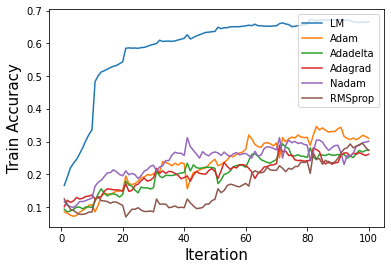

In [ ]:
# Plotting both the curves simultaneously
x_values1=list(range(1,100+1))

plt.plot(x_values1, model_wrapper.trainer.batch_end_acc, color='C0', label='LM')
plt.plot(x_values1, batch_end_acc1, color='C1', label='Adam')
plt.plot(x_values1, batch_end_acc2, color='C2', label='Adadelta')
plt.plot(x_values1, batch_end_acc3, color='C3', label='Adagrad')
plt.plot(x_values1, batch_end_acc4, color='C4', label='Nadam')
plt.plot(x_values1, batch_end_acc5, color='C5', label='RMSprop')


# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Iteration", fontsize = 15)
plt.ylabel("Train Accuracy", fontsize = 15)

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(prop={'size': 10}, loc = 1)

# To load the display window
plt.show()